In [1]:
import torch
from torch.utils.data import DataLoader
import albumentations as A
from datasets import GTA5, CityScapes
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from models.bisenet.build_bisenet import BiSeNet
from training import train
from model_evaluation import save_results
from visualization import  plot_loss, plot_mIoU, plot_IoU
from config import BATCH_SIZE, NC, NUM_WORKERS, CITYSCAPE_SIZE, GTA5_SIZE, EPOCHS, CITYSCAPES_MEAN, CITYSCAPES_STD, GTA5_MEAN, GTA5_STD
torch.cuda.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:

transforms = A.Compose([
    A.Resize(CITYSCAPE_SIZE[0], CITYSCAPE_SIZE[1]),
    A.Normalize(mean=[78.5451/255, 87.7702/255, 76.9778/255], std=[47.7790/255, 48.5031/255, 47.8005/255]),
])
transforms_GTA5 = A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.Normalize(mean=[129.5363/255, 127.9398/255, 123.2765/255], std=[63.8022/255, 62.4980/255, 62.0512/255]),


])

cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transforms)
cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transforms)
GTA5_dataset = GTA5('./GTA5', transform=transforms_GTA5)

cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# cityscapes_mean, city_scapes_std = calculate_mean_std(cityscapes_train_dataloader)
# GTA5_mean, GTA5_std = calculate_mean_std(GTA5_dataloader)

len(cityscapes_train_dataloader)

393

## 2.1 DeepLabV2

In [ ]:

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
init_lr = 7.5e-4
model_deeplab = get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='./models/deeplab_resnet_pretrained_imagenet.pth').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_deeplab = torch.nn.DataParallel(model_deeplab).to(device)
optimizer_deeplab = torch.optim.Adam(model_deeplab.parameters(), lr=init_lr)

deeplab_result = train(model = model_deeplab,
                       optimizer = optimizer_deeplab,
                       loss_fn = loss_fn, 
                       train_dataloader = cityscapes_train_dataloader,
                       validation_dataloader = cityscapes_test_dataloader, 
                       epochs = EPOCHS,
                       device = device,
                       model_name = "deeplab",
                       class_number= NC)

In [ ]:
save_results(model_deeplab, deeplab_result, "deeplab_performance_metrics_2_1", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
plot_loss(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")
plot_mIoU(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")
plot_IoU(deeplab_result, "DeepLabV2", "step2_1", "CityScapes", "CityScapes")

torch.save(model_deeplab.state_dict(), "./checkpoints/deeplab_model_2_1.pth")

## 2.2 BiseNet


In [ ]:
init_lr = 7.5e-4
model_bisenet = BiSeNet(NC, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet = torch.nn.DataParallel(model_bisenet).to(device)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer_bisenet = torch.optim.Adam(model_bisenet.parameters(), lr=init_lr)

bisenet_result_2_2 = train(model = model_bisenet,
                           optimizer = optimizer_bisenet,
                           loss_fn = loss_fn, 
                           train_dataloader = cityscapes_train_dataloader,
                           validation_dataloader = cityscapes_test_dataloader, 
                           epochs = EPOCHS,
                           device = device,
                           model_name = "bisenet",
                           class_number= NC)



In [ ]:

import importlib
import model_evaluation
importlib.reload(model_evaluation)
from model_evaluation import save_results
model_bisenet.eval()
save_results(model_bisenet, bisenet_result_2_2, "bisenet_performance_metrics_2_2", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100)
plot_loss(bisenet_result_2_2, "BiSeNet", "step2_2", "CityScapes", "CityScapes")
plot_mIoU(bisenet_result_2_2, "BiSeNet", "step2_2", "CityScapes", "CityScapes")
plot_IoU(bisenet_result_2_2, "BiSeNet", "step2_2", "CityScapes", "CityScapes")
torch.save(model_bisenet.state_dict(), "./checkpoints/bisenet_model_2_2.pth")

## 3.1 Bisenet

In [ ]:
model_bisenet_3_1 = BiSeNet(19, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_3_1 = torch.nn.DataParallel(model_bisenet_3_1).to(device)
init_lr = 7.5e-4
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer_bisenet_3_1 = torch.optim.Adam(model_bisenet_3_1.parameters(), lr=init_lr)
bisenet_result_3_1 = train(model=model_bisenet_3_1,
                           optimizer=optimizer_bisenet_3_1,
                           loss_fn=loss_fn,
                           train_dataloader=GTA5_dataloader,
                           validation_dataloader=cityscapes_test_dataloader,
                           epochs=EPOCHS,
                           device=device,
                           model_name="bisenet",
                           class_number=NC)



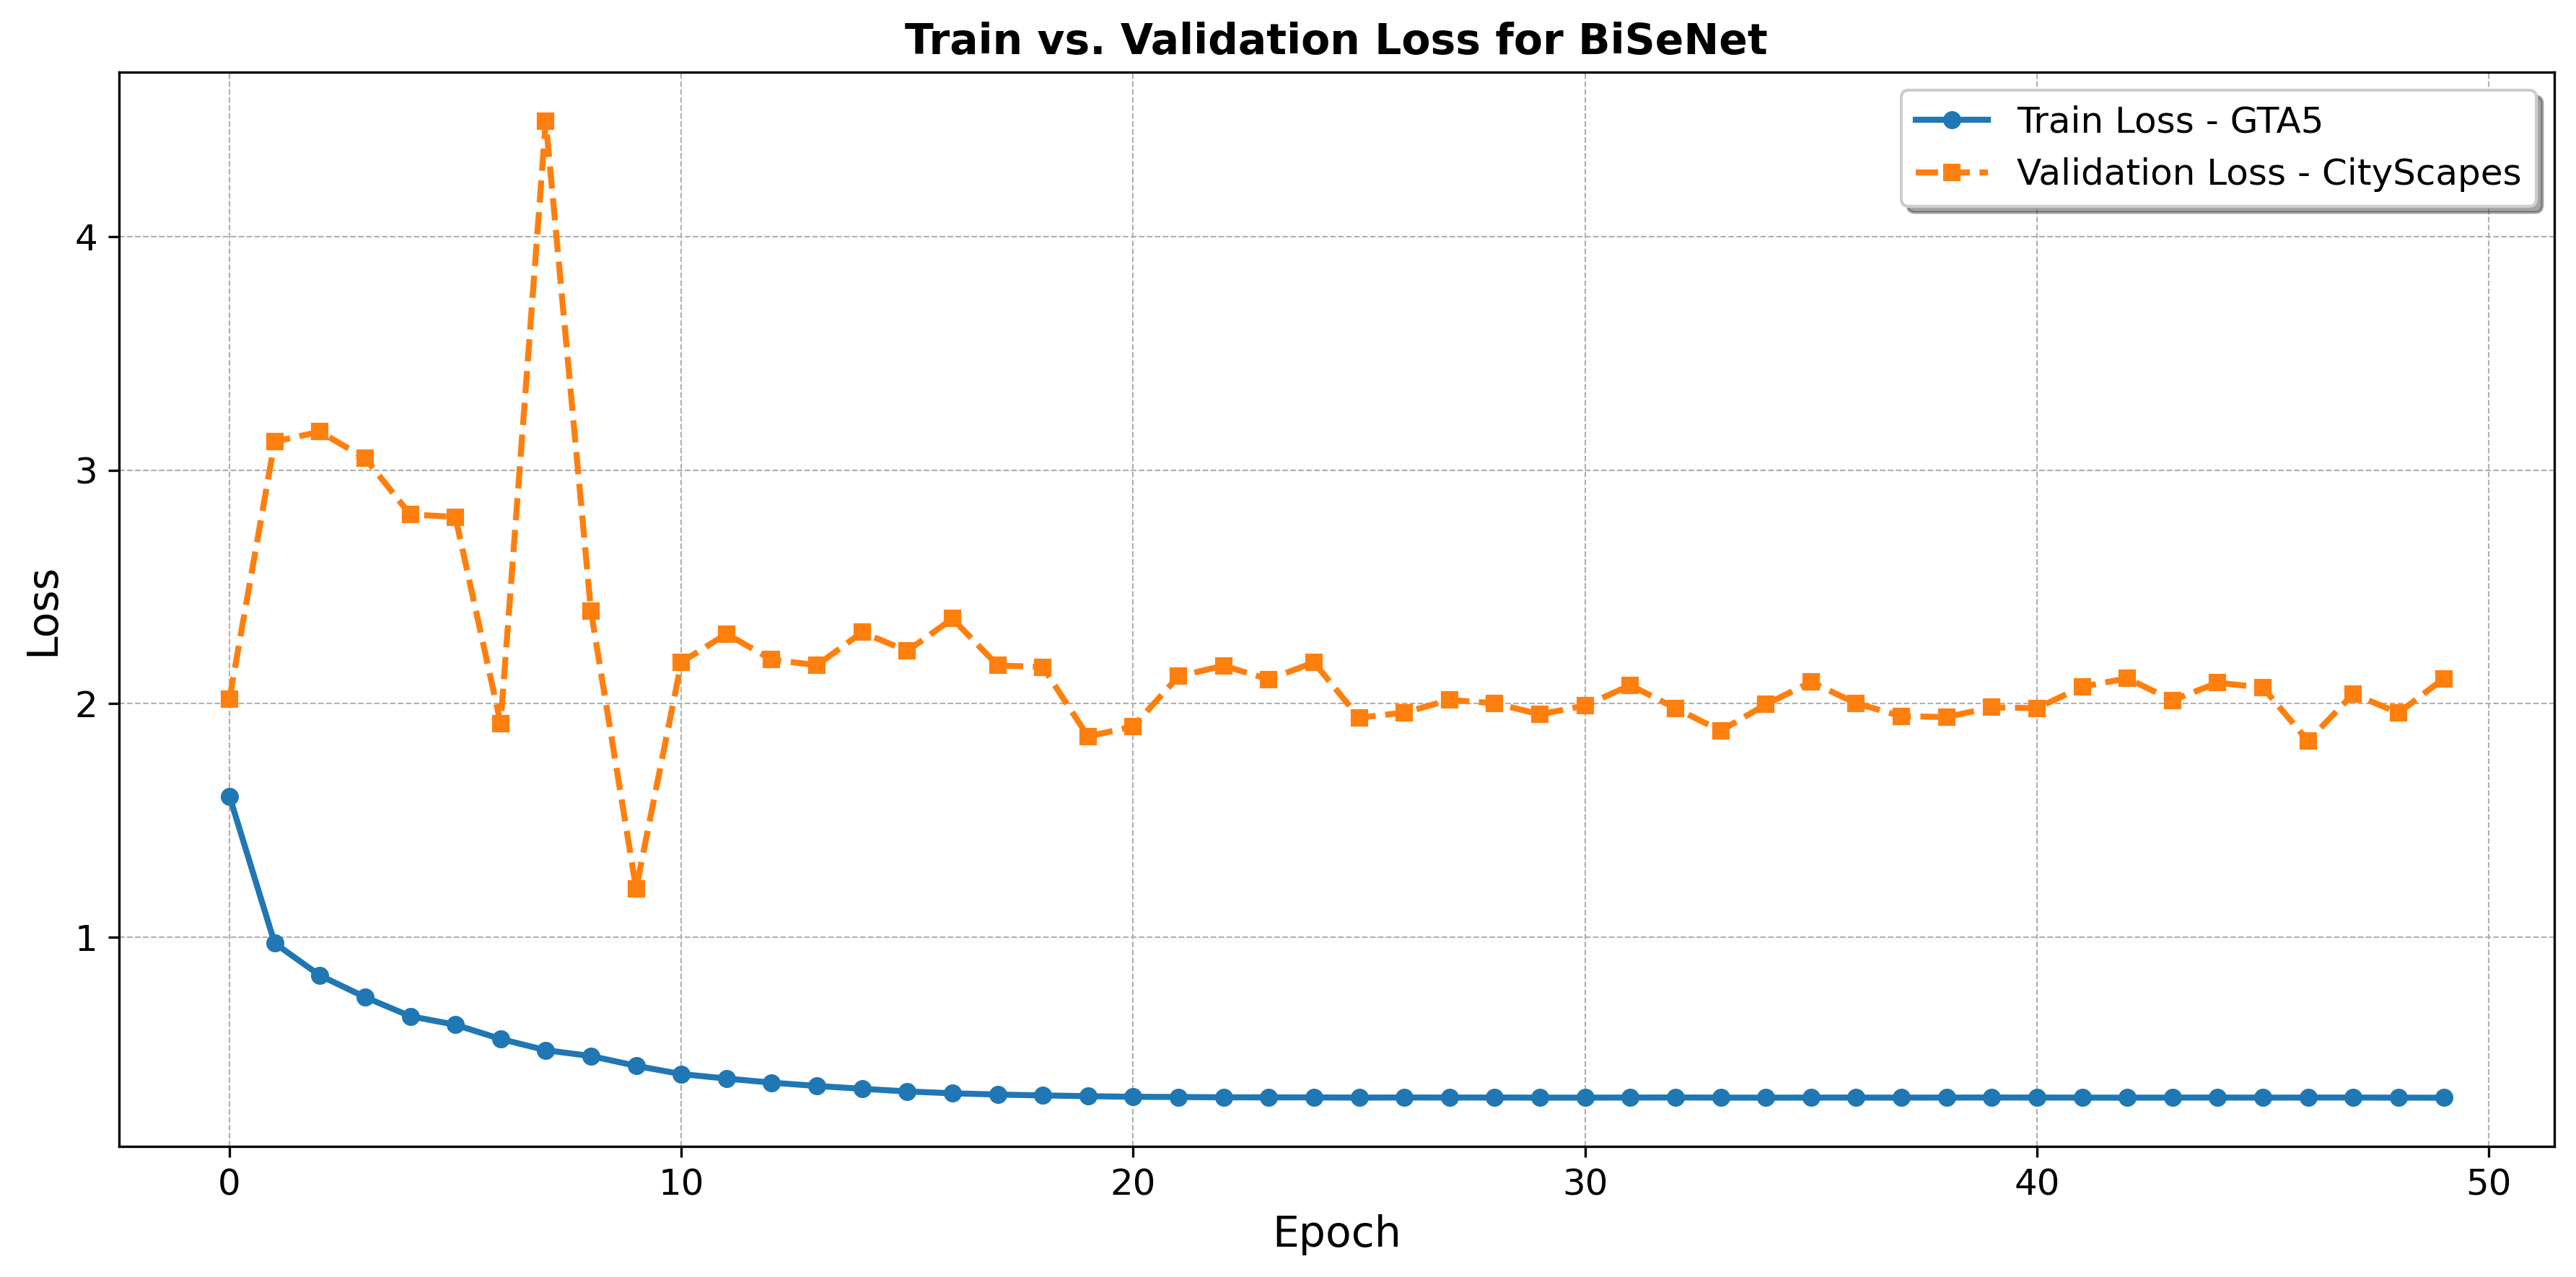

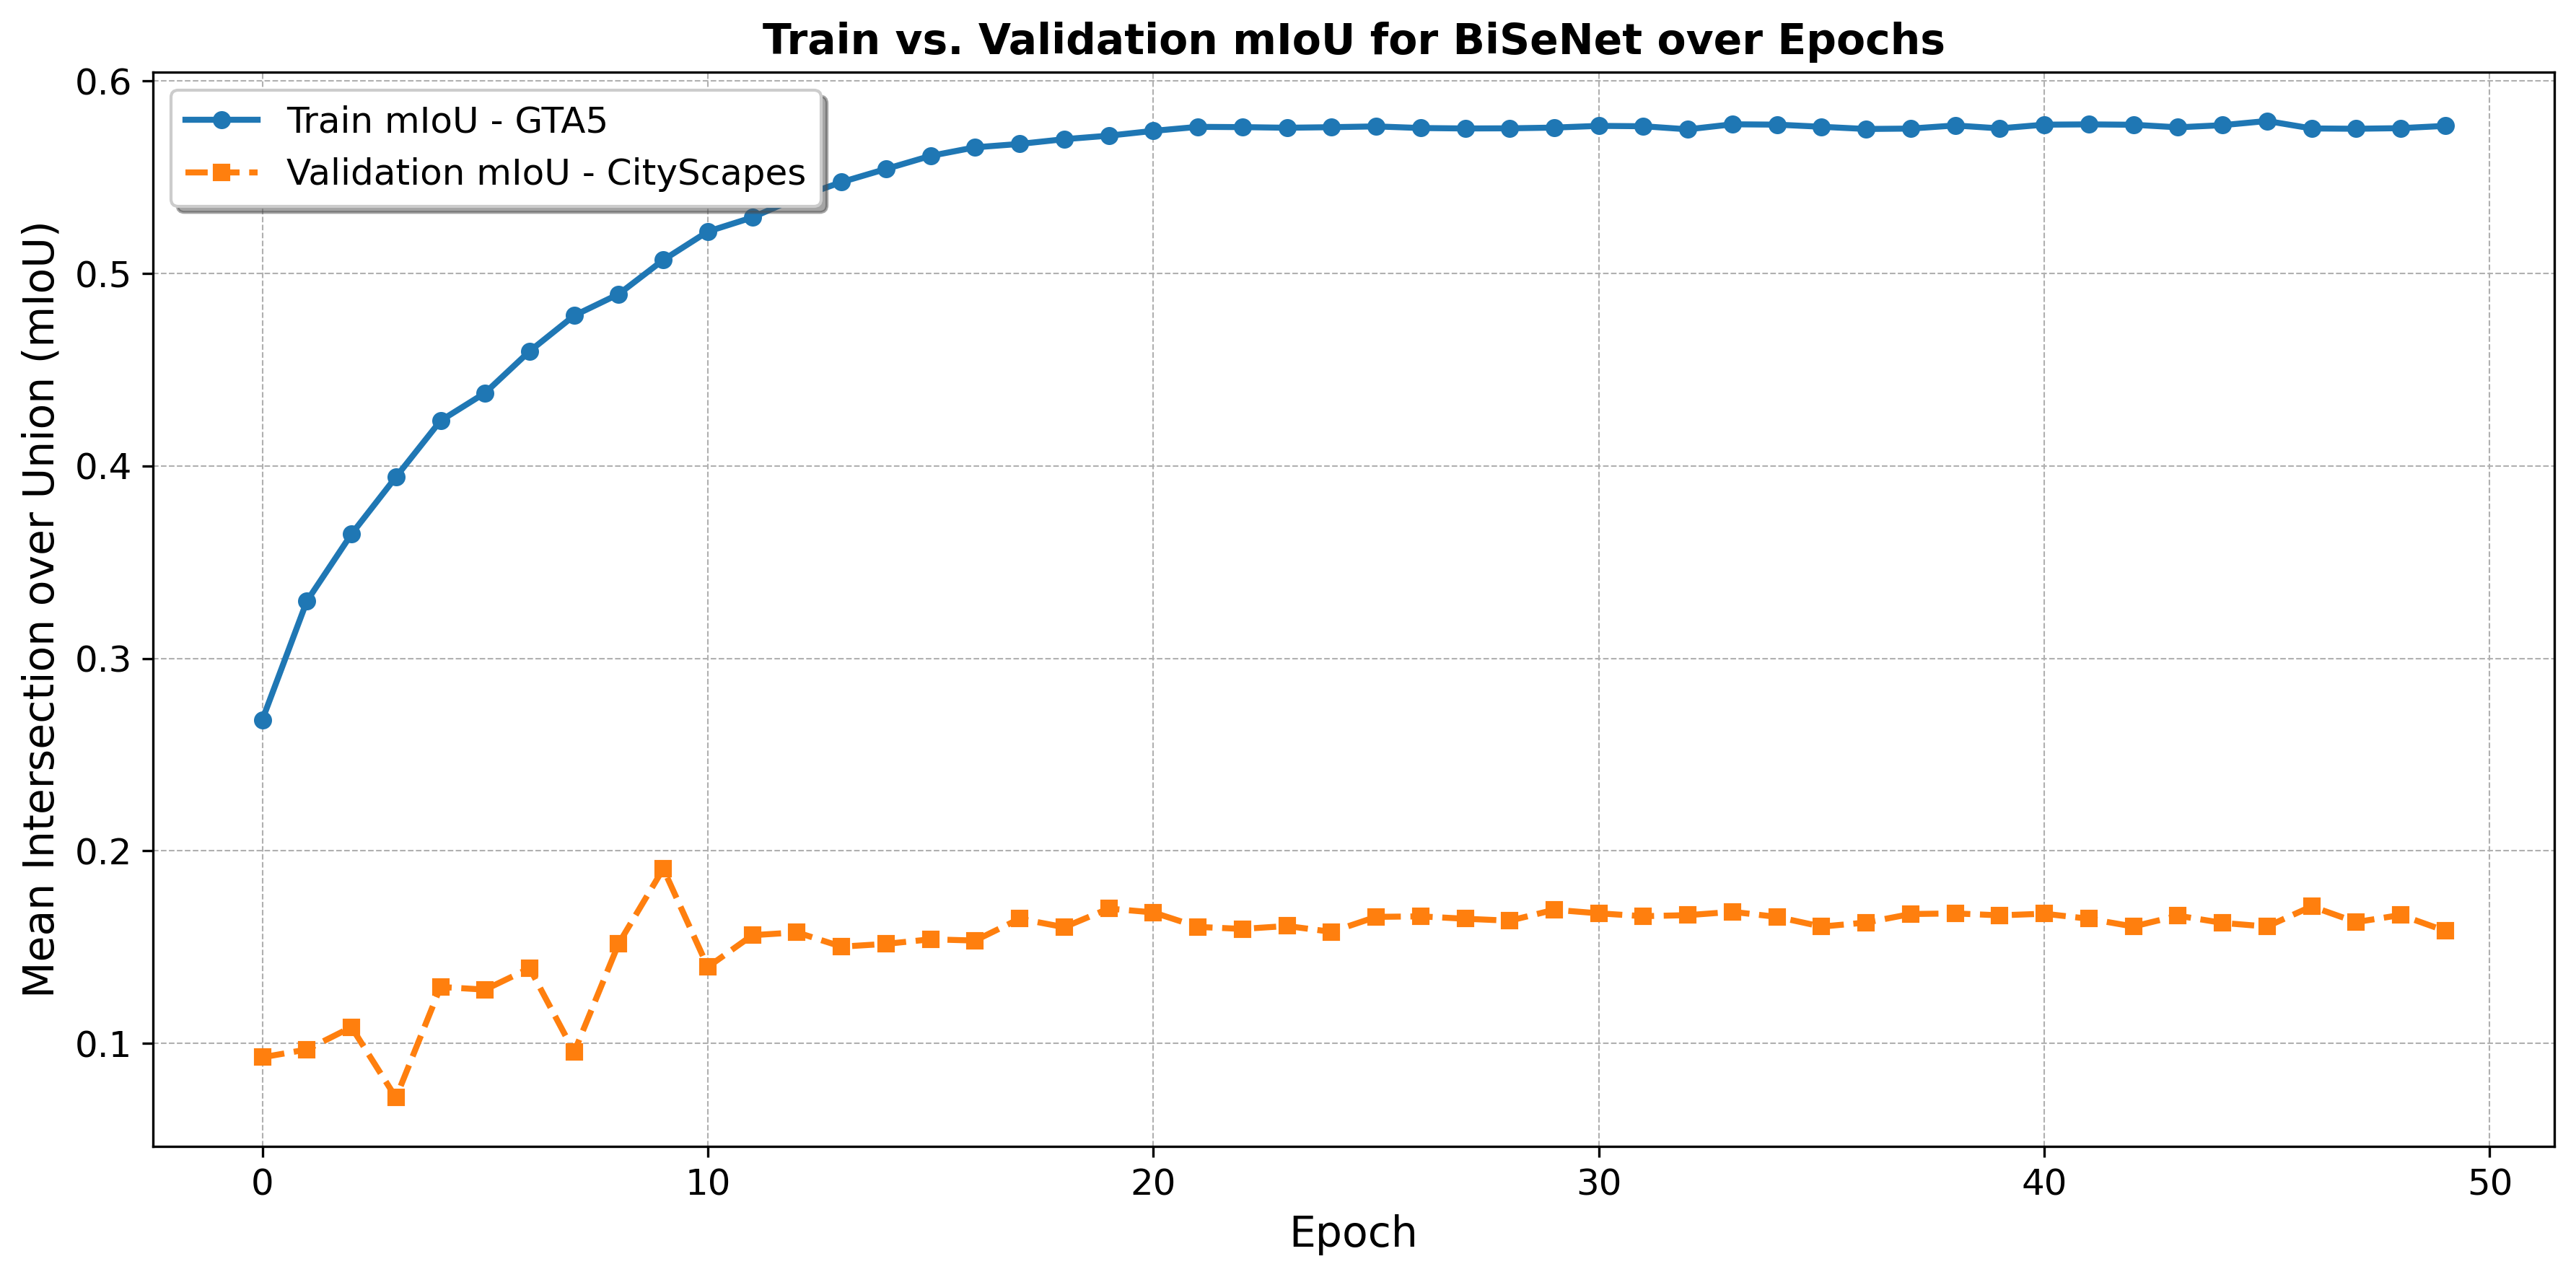

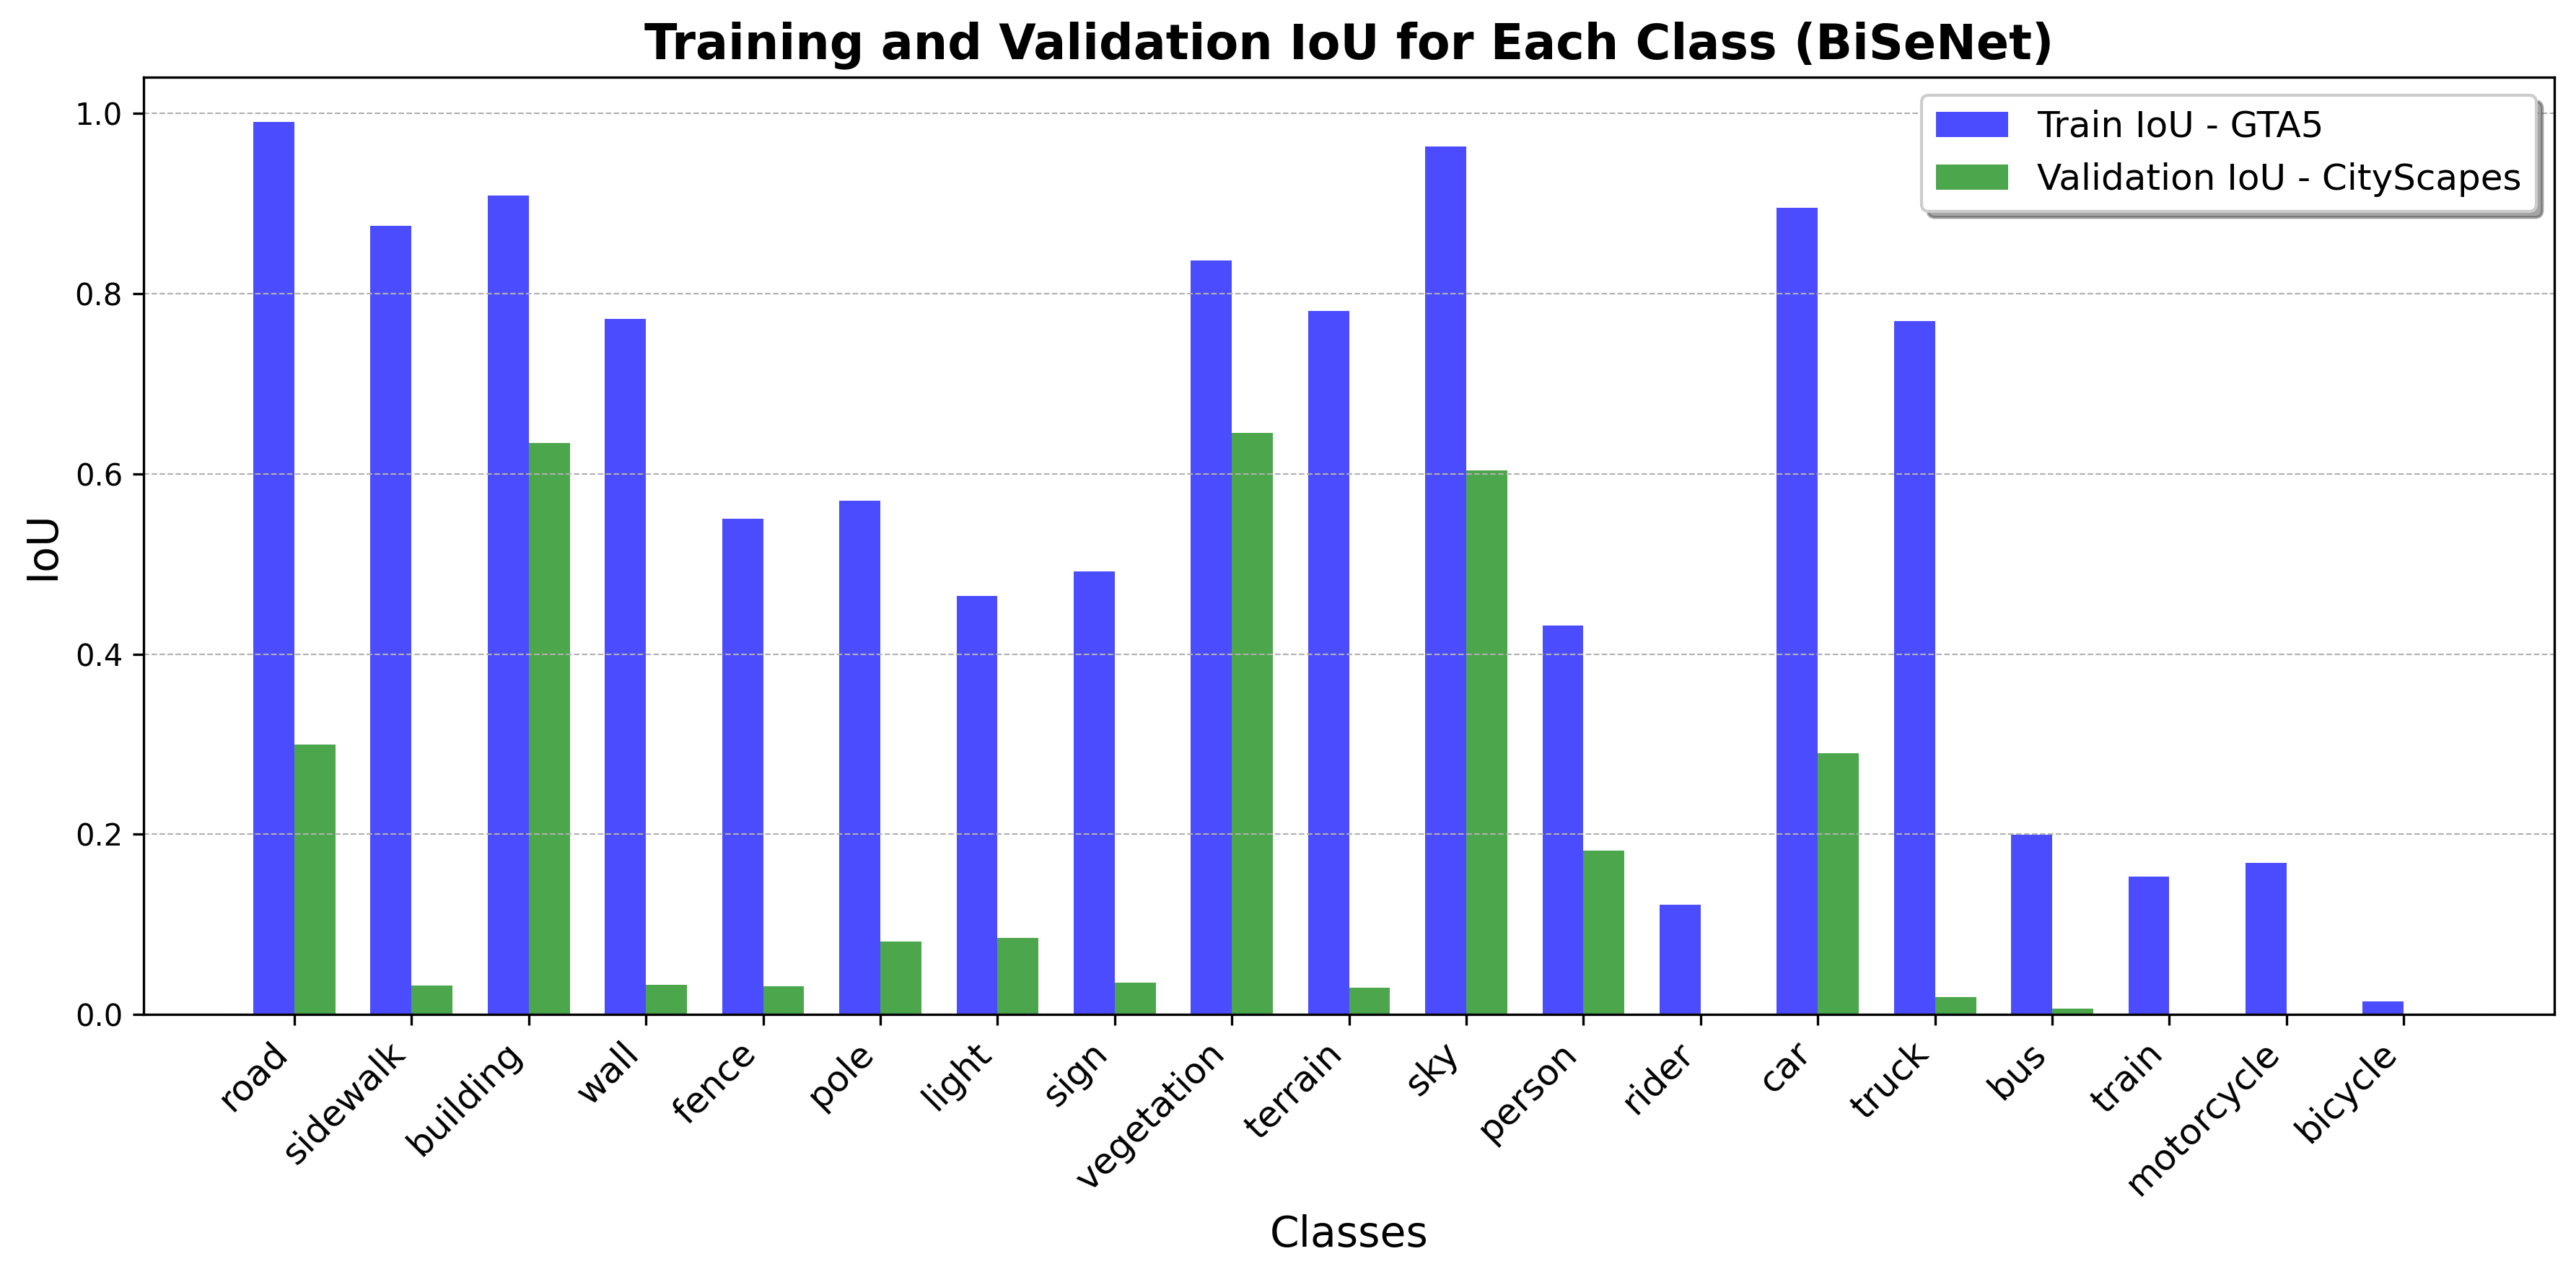

In [4]:
save_results(model_bisenet_3_1, bisenet_result_3_1, "bisenet_performance_metrics_3_1", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=1000, device=device)
plot_loss(bisenet_result_3_1, "BiSeNet", "step3_1", "GTA5", "CityScapes")
plot_mIoU(bisenet_result_3_1, "BiSeNet", "step3_1", "GTA5", "CityScapes")
plot_IoU(bisenet_result_3_1, "BiSeNet", "step3_1", "GTA5", "CityScapes")
torch.save(model_bisenet_3_1.state_dict(), "./checkpoints/bisenet_model_3_1.pth")

## 3.2 Bisenet with augmentation



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.6809022549629211, Validation Loss: 1.9379334020614625
Train mIoU: 0.24897140770935894, Validation mIoU: 0.13900835827642435
Epoch: 1
Train Loss: 1.0220752470970154, Validation Loss: 1.0971738138198852
Train mIoU: 0.3188987420190137, Validation mIoU: 0.17594692559568778
Epoch: 2
Train Loss: 0.8671262042045593, Validation Loss: 1.3027494649887086
Train mIoU: 0.3614709522619018, Validation mIoU: 0.16523064092466075
Epoch: 3
Train Loss: 0.7754203851222992, Validation Loss: 1.0539103422164917
Train mIoU: 0.38935798184261644, Validation mIoU: 0.187523063406041
Epoch: 4
Train Loss: 0.7001771262168884, Validation Loss: 2.5431134328842164
Train mIoU: 0.4109229772385344, Validation mIoU: 0.107439931143819
Epoch: 5
Train Loss: 0.6381173612117768, Validation Loss: 1.386439215183258
Train mIoU: 0.4321909232425338, Validation mIoU: 0.1646292961190488
Epoch: 6
Train Loss: 0.6009546480178833, Validation Loss: 1.2367559022903443
Train mIoU: 0.44580871944400025, Validation mIoU: 0

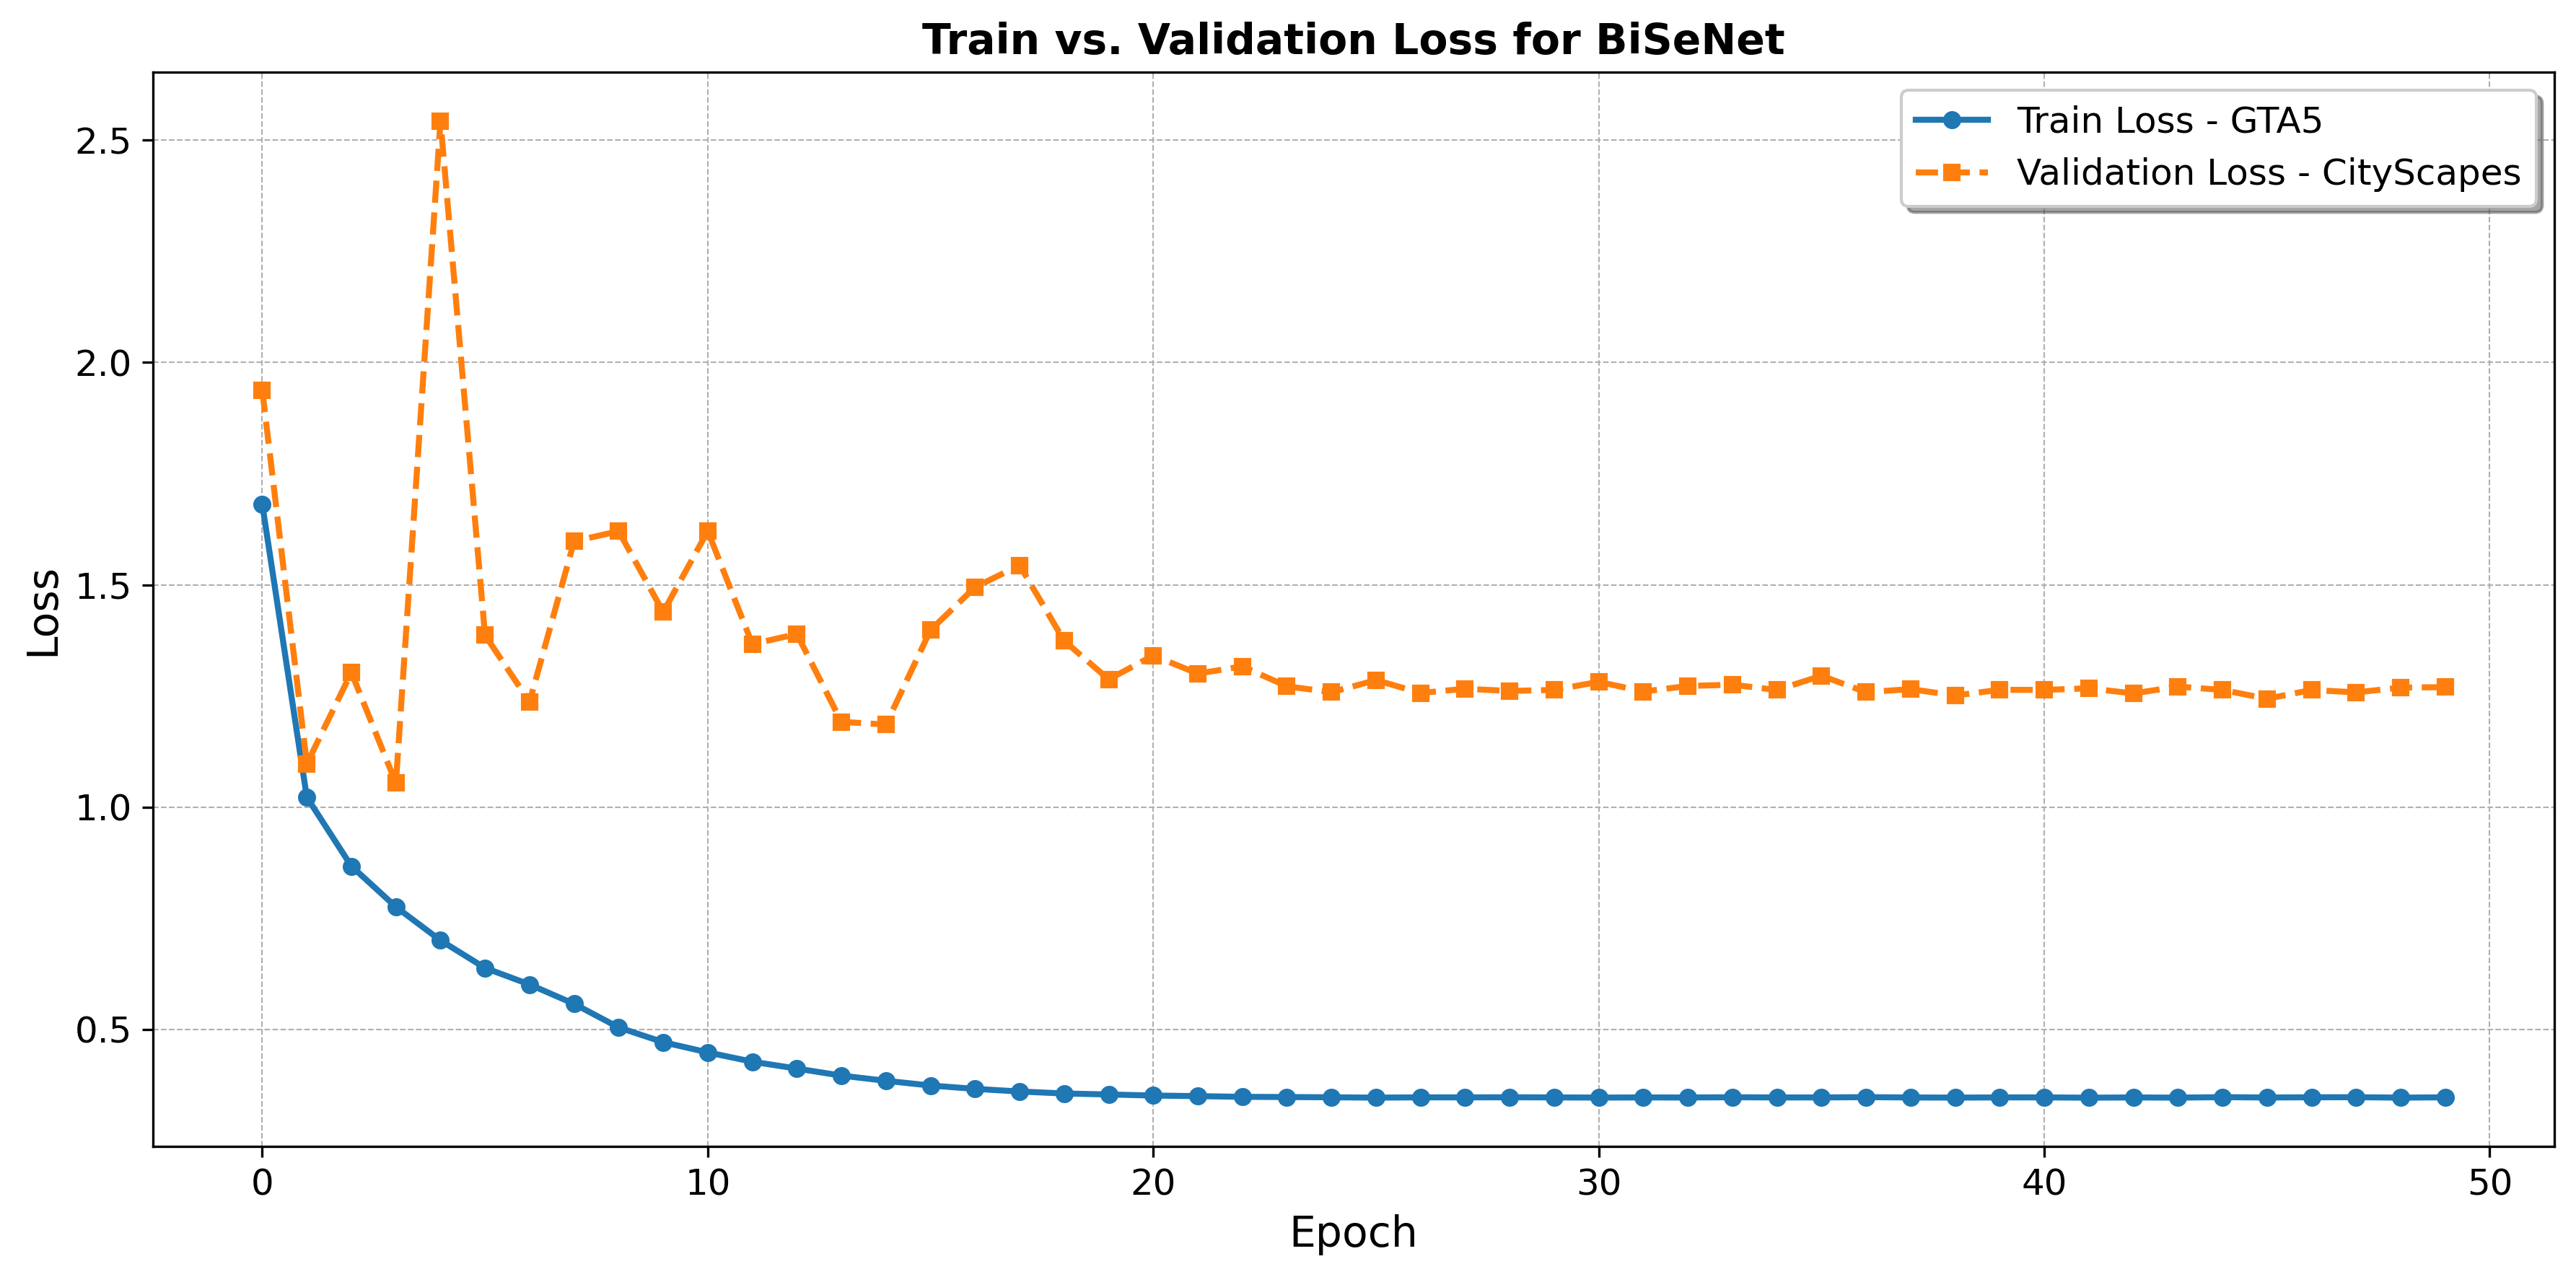

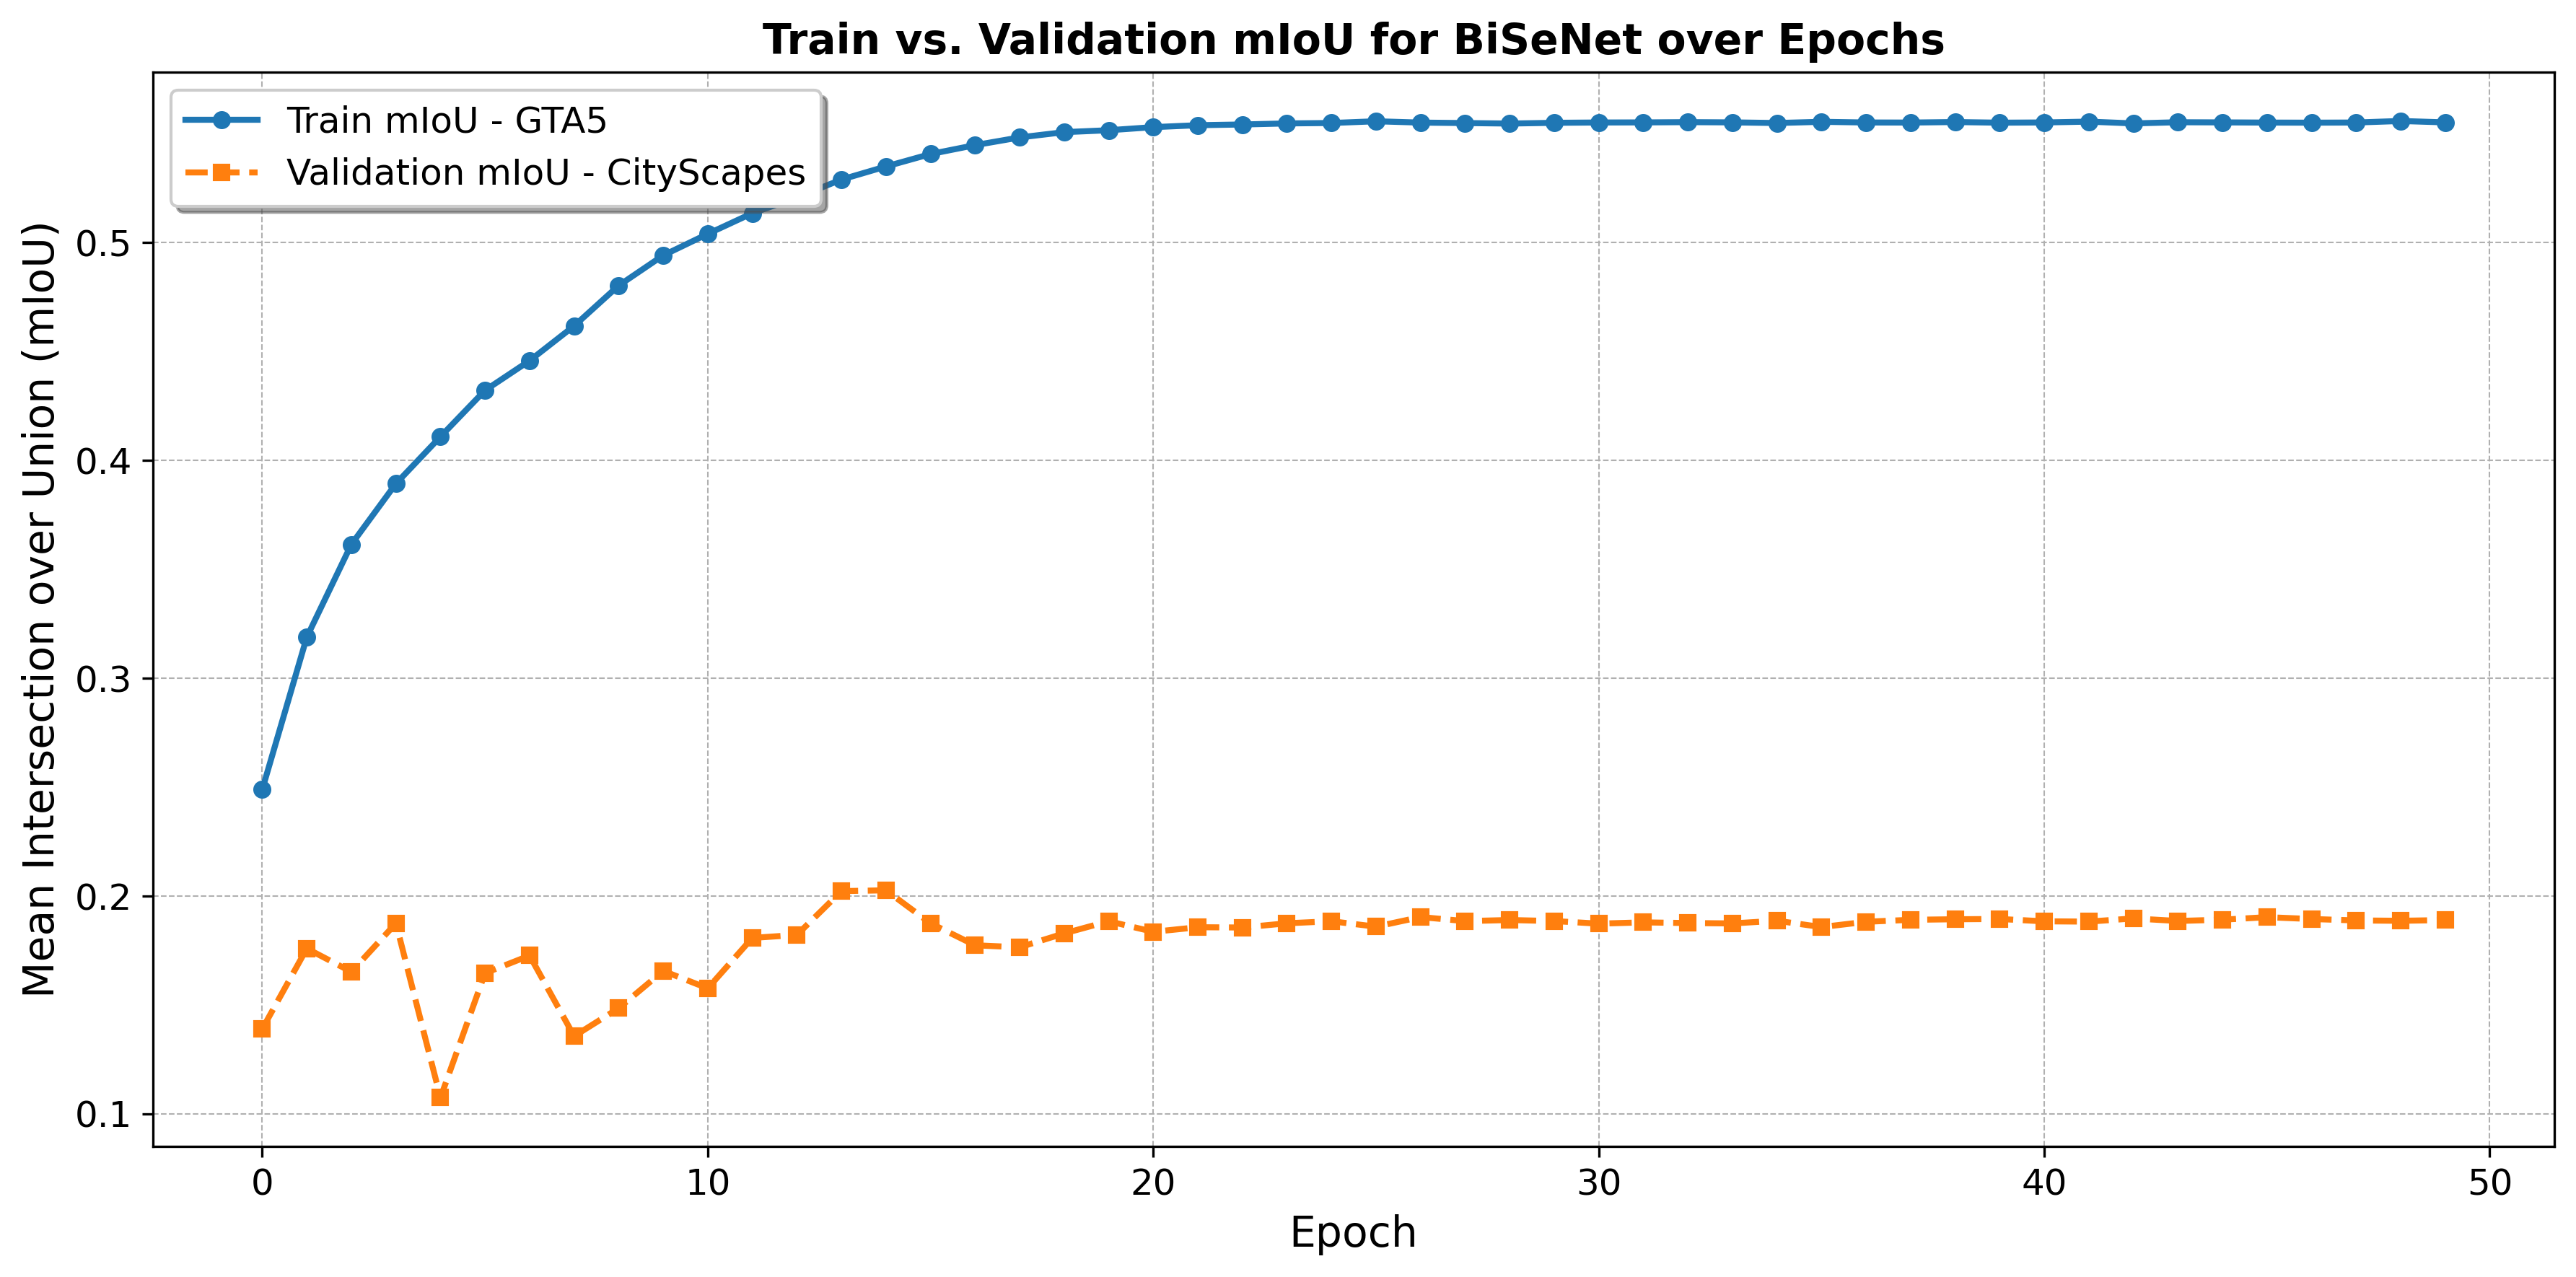

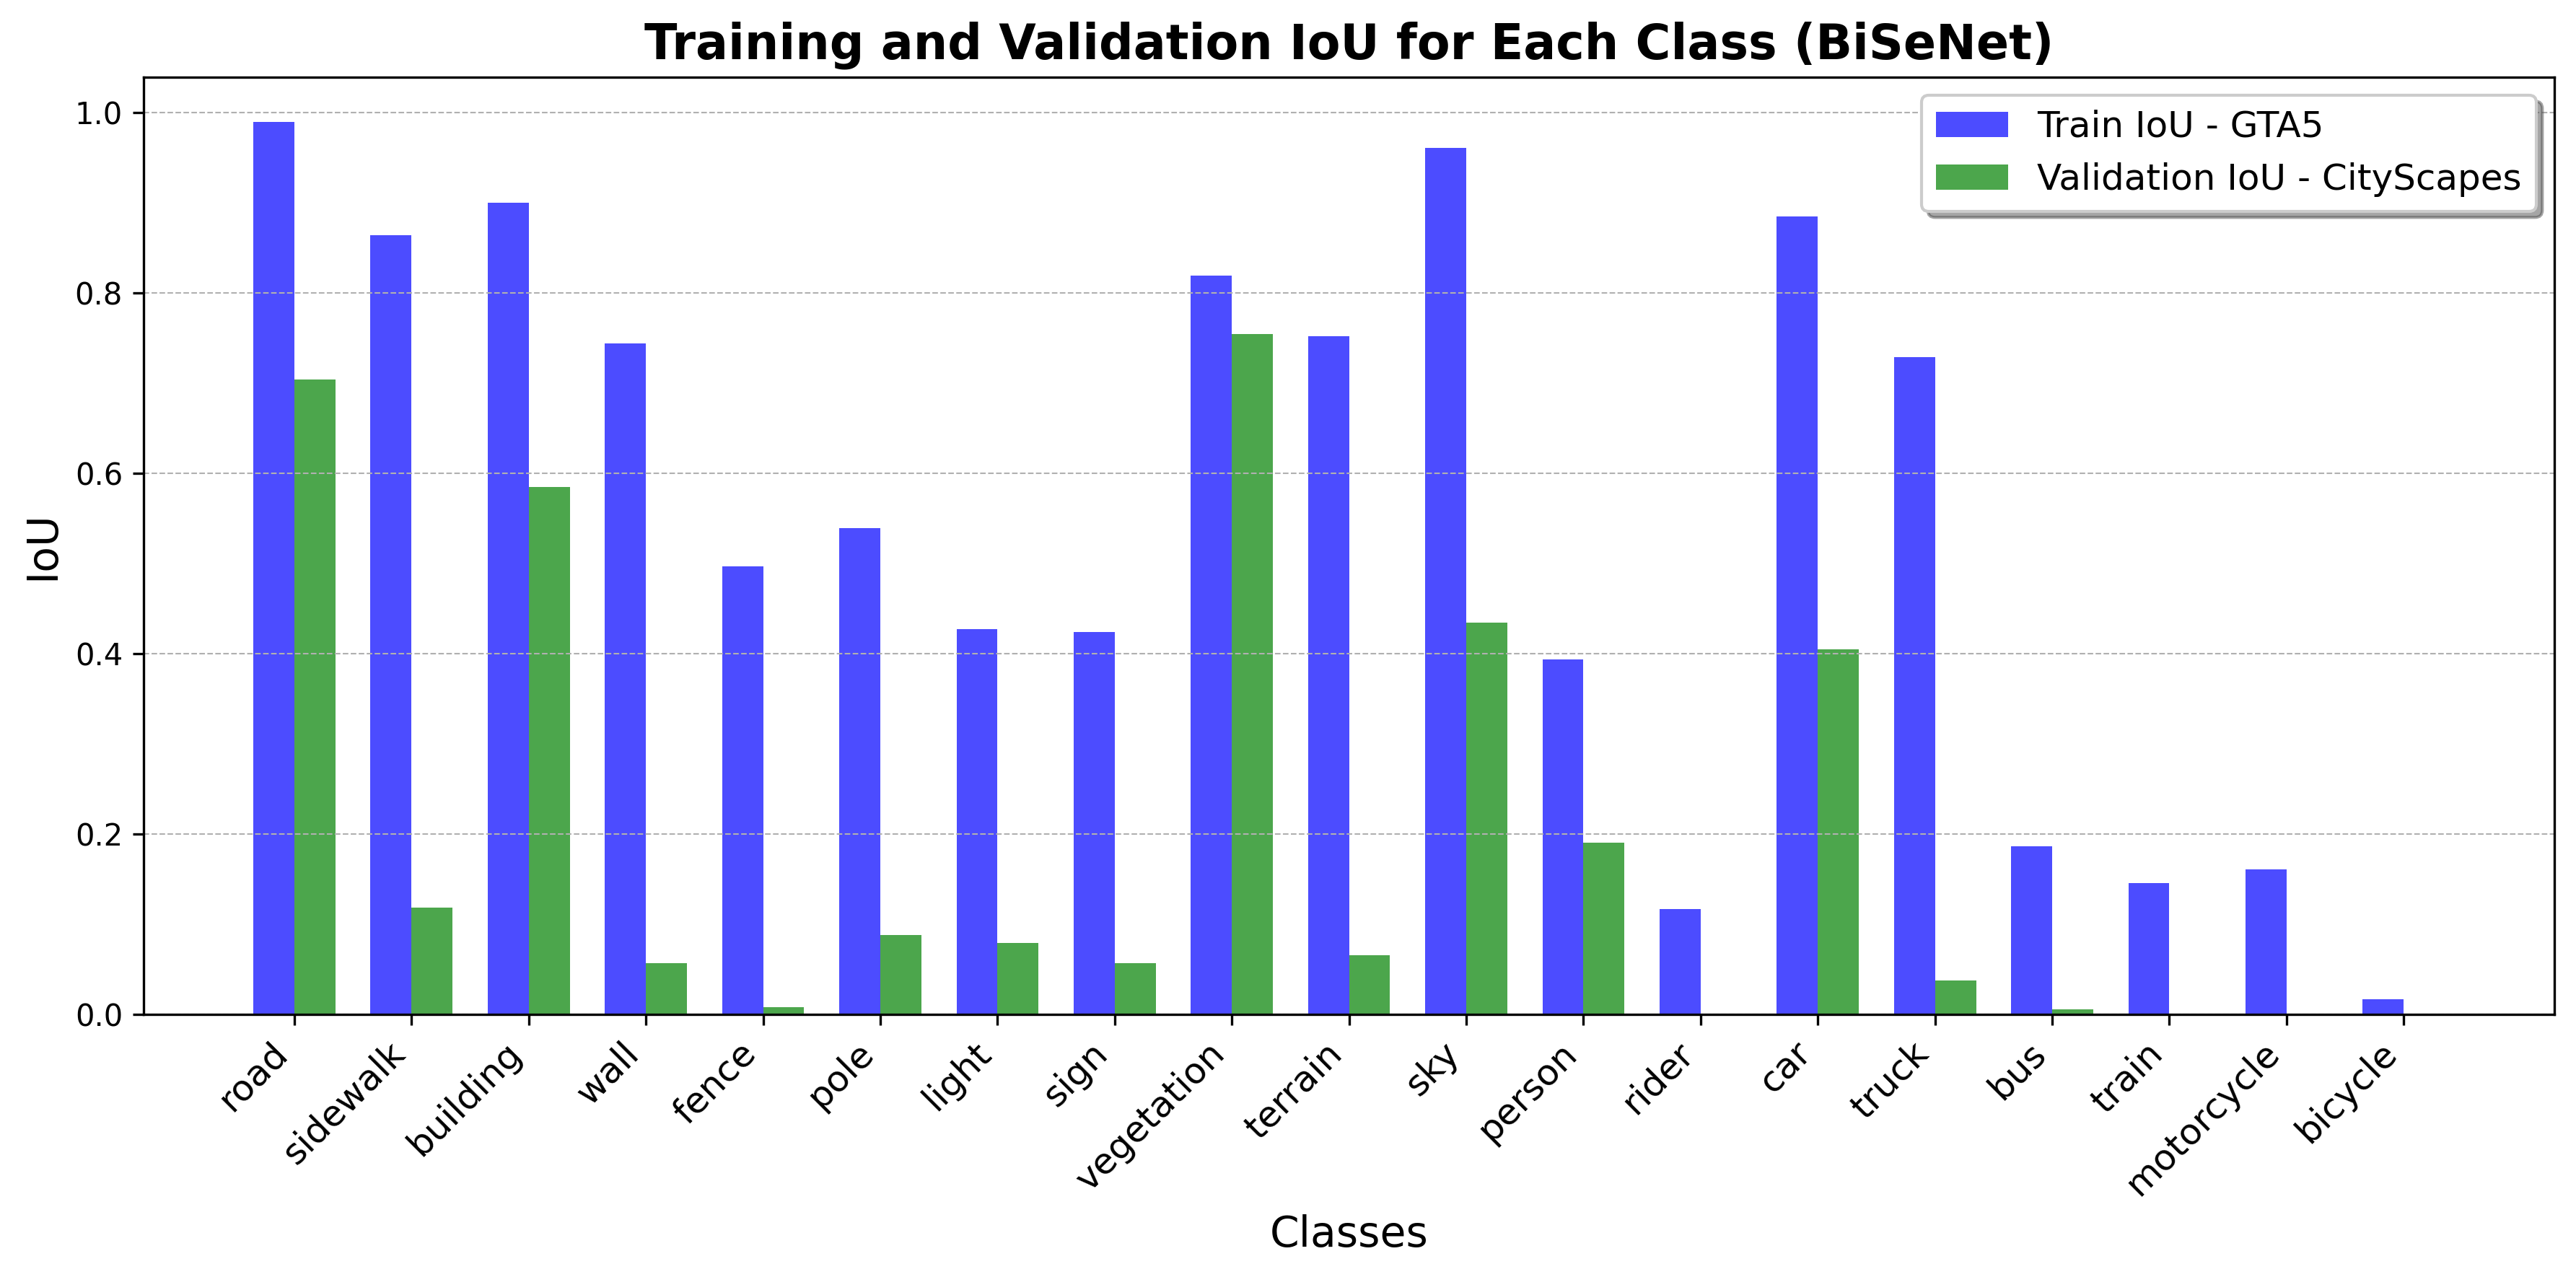

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.6795403655052186, Validation Loss: 1.0940489506721496
Train mIoU: 0.24867813253117585, Validation mIoU: 0.1706691465413813
Epoch: 1
Train Loss: 1.0615449280738831, Validation Loss: 0.971661431312561
Train mIoU: 0.3145729291418012, Validation mIoU: 0.1914987566756484
Epoch: 2
Train Loss: 0.8856559473991394, Validation Loss: 0.9770471925735473
Train mIoU: 0.352586258664418, Validation mIoU: 0.19817763044595094
Epoch: 3
Train Loss: 0.7854485720634461, Validation Loss: 0.9303227400779724
Train mIoU: 0.38219543487201685, Validation mIoU: 0.20054446963490327
Epoch: 4
Train Loss: 0.7126036393642425, Validation Loss: 0.9398562841415405
Train mIoU: 0.4064088336914936, Validation mIoU: 0.2327744452534699
Epoch: 5
Train Loss: 0.6347979437351227, Validation Loss: 1.2794234290122986
Train mIoU: 0.4304437163447041, Validation mIoU: 0.2099226055416825
Epoch: 6
Train Loss: 0.5769104058742524, Validation Loss: 1.100277354478836
Train mIoU: 0.452446179607757, Validation mIoU: 0.21

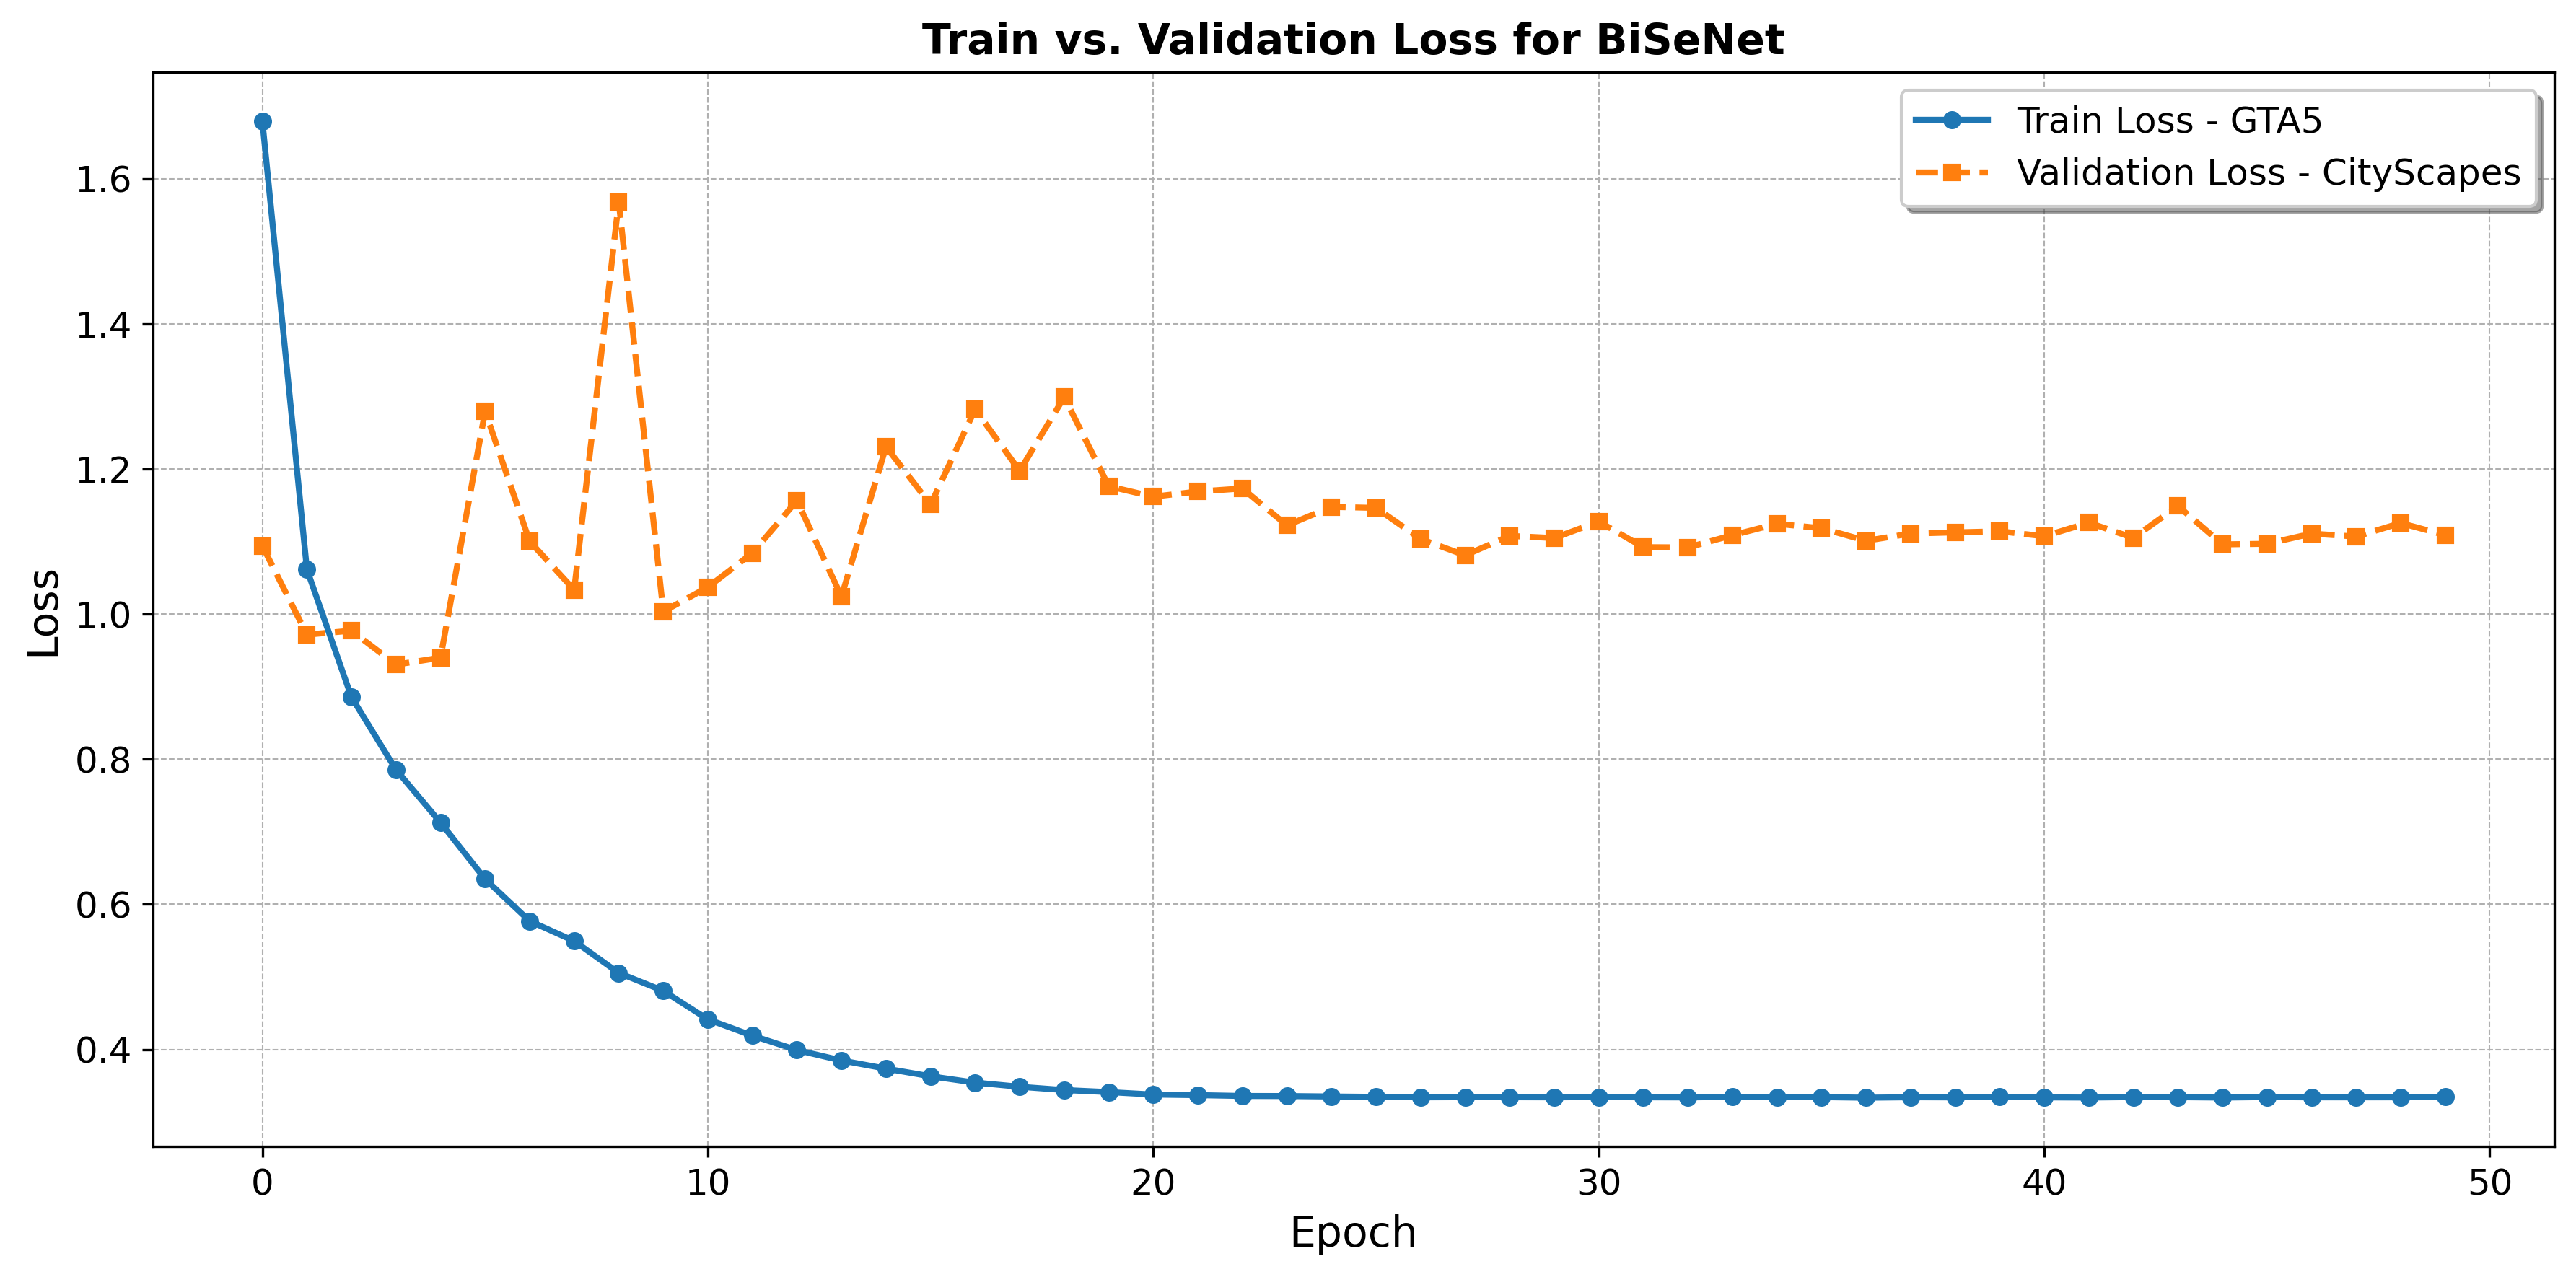

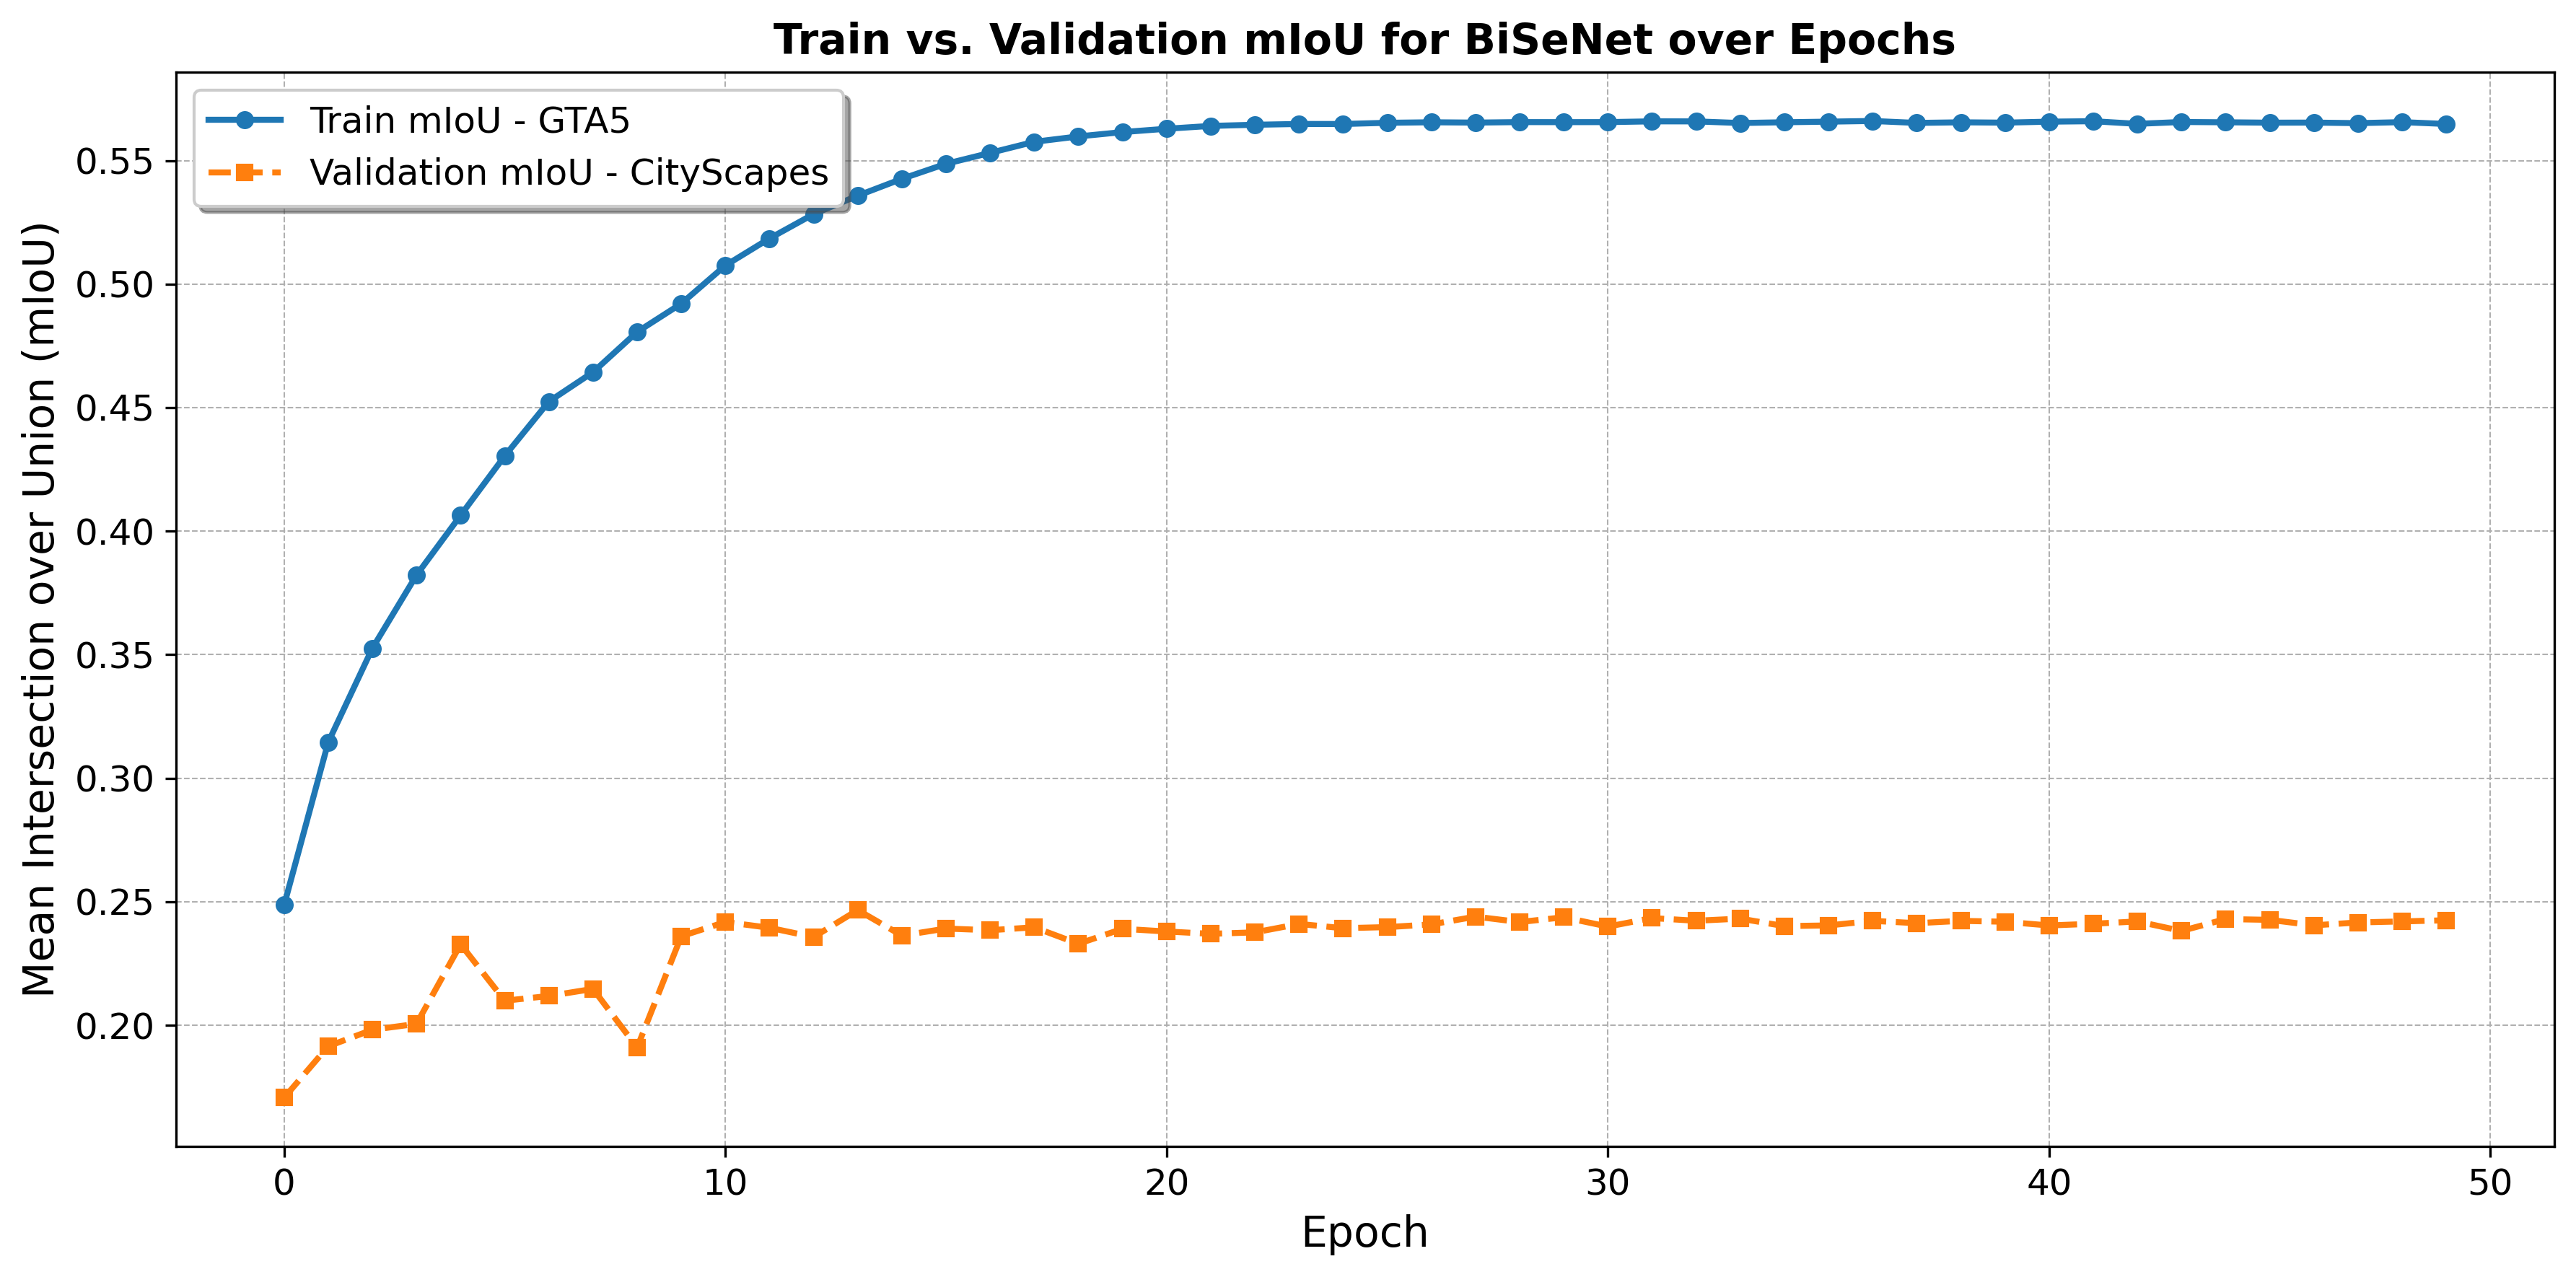

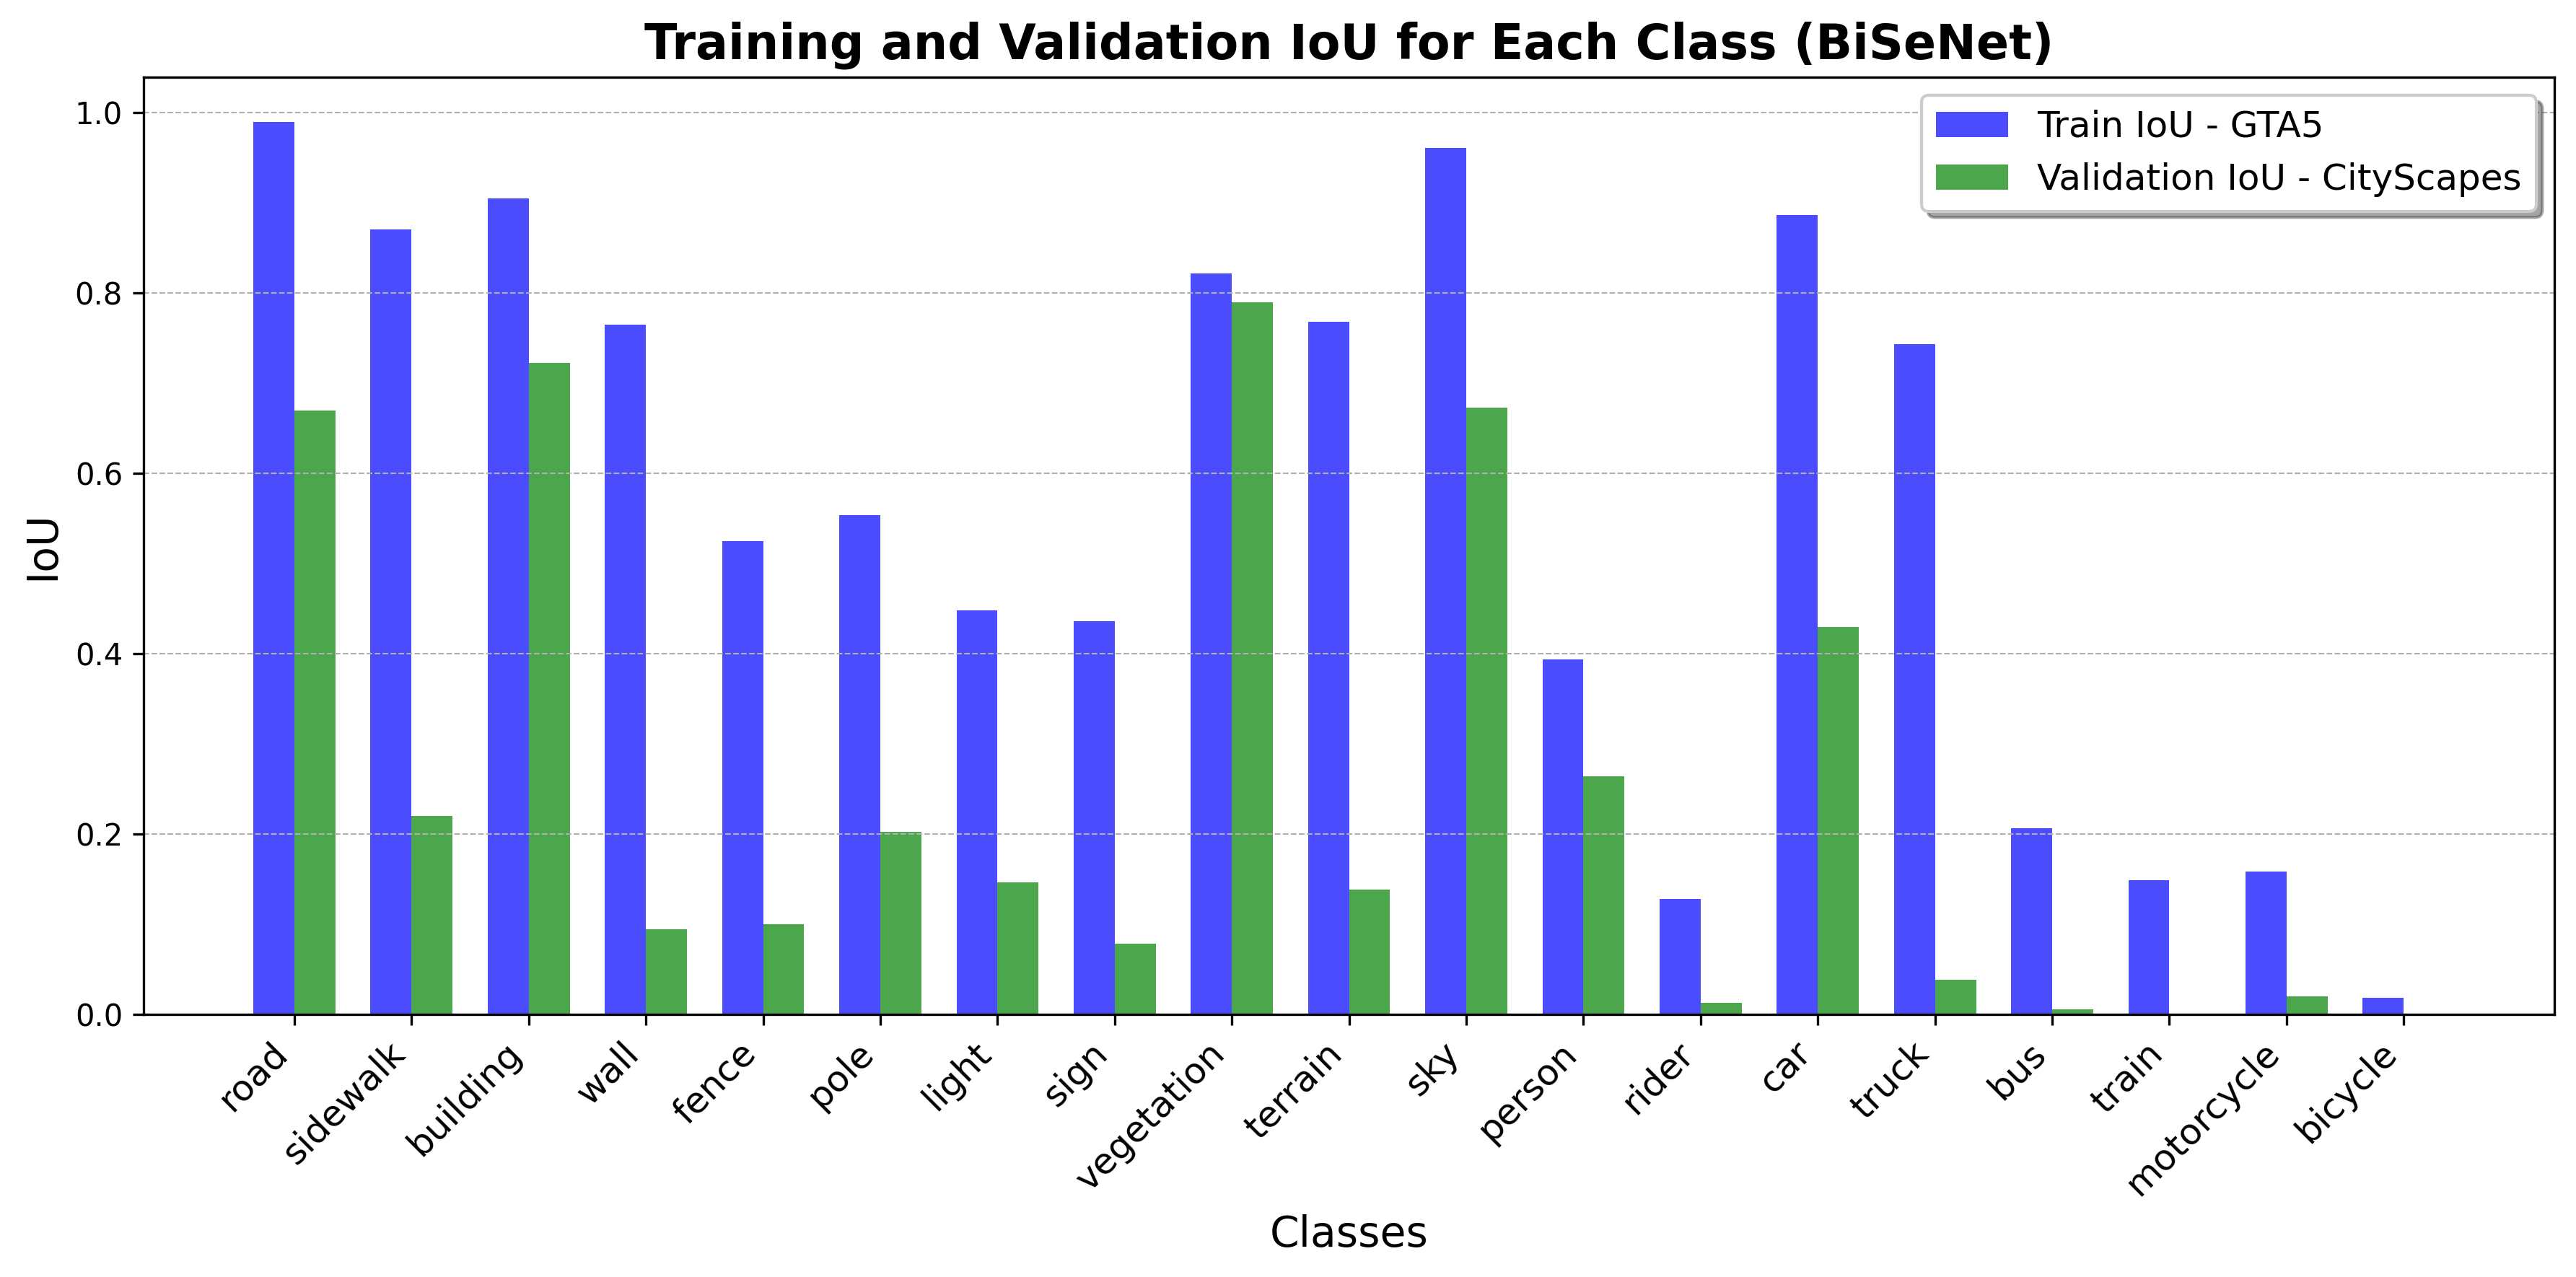

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.7286418249130249, Validation Loss: 1.084763837337494
Train mIoU: 0.24701261478612552, Validation mIoU: 0.18547183608267565
Epoch: 1
Train Loss: 1.0748709331512452, Validation Loss: 1.1441941437721252
Train mIoU: 0.30838441444599696, Validation mIoU: 0.1833324169575627
Epoch: 2
Train Loss: 0.9230133741378784, Validation Loss: 1.2022968277931214
Train mIoU: 0.3406676273944753, Validation mIoU: 0.20542786361472776
Epoch: 3
Train Loss: 0.822494730091095, Validation Loss: 1.1794388399124145
Train mIoU: 0.37033143007186237, Validation mIoU: 0.19650446916245776
Epoch: 4
Train Loss: 0.7453567236423493, Validation Loss: 1.1044436361789702
Train mIoU: 0.3936310266830917, Validation mIoU: 0.2107489820488661
Epoch: 5
Train Loss: 0.6855224417209625, Validation Loss: 1.491125418663025
Train mIoU: 0.41309727086912523, Validation mIoU: 0.18368226416339553
Epoch: 6
Train Loss: 0.6288214673519135, Validation Loss: 1.2121974573135377
Train mIoU: 0.4326754524285629, Validation mIoU:

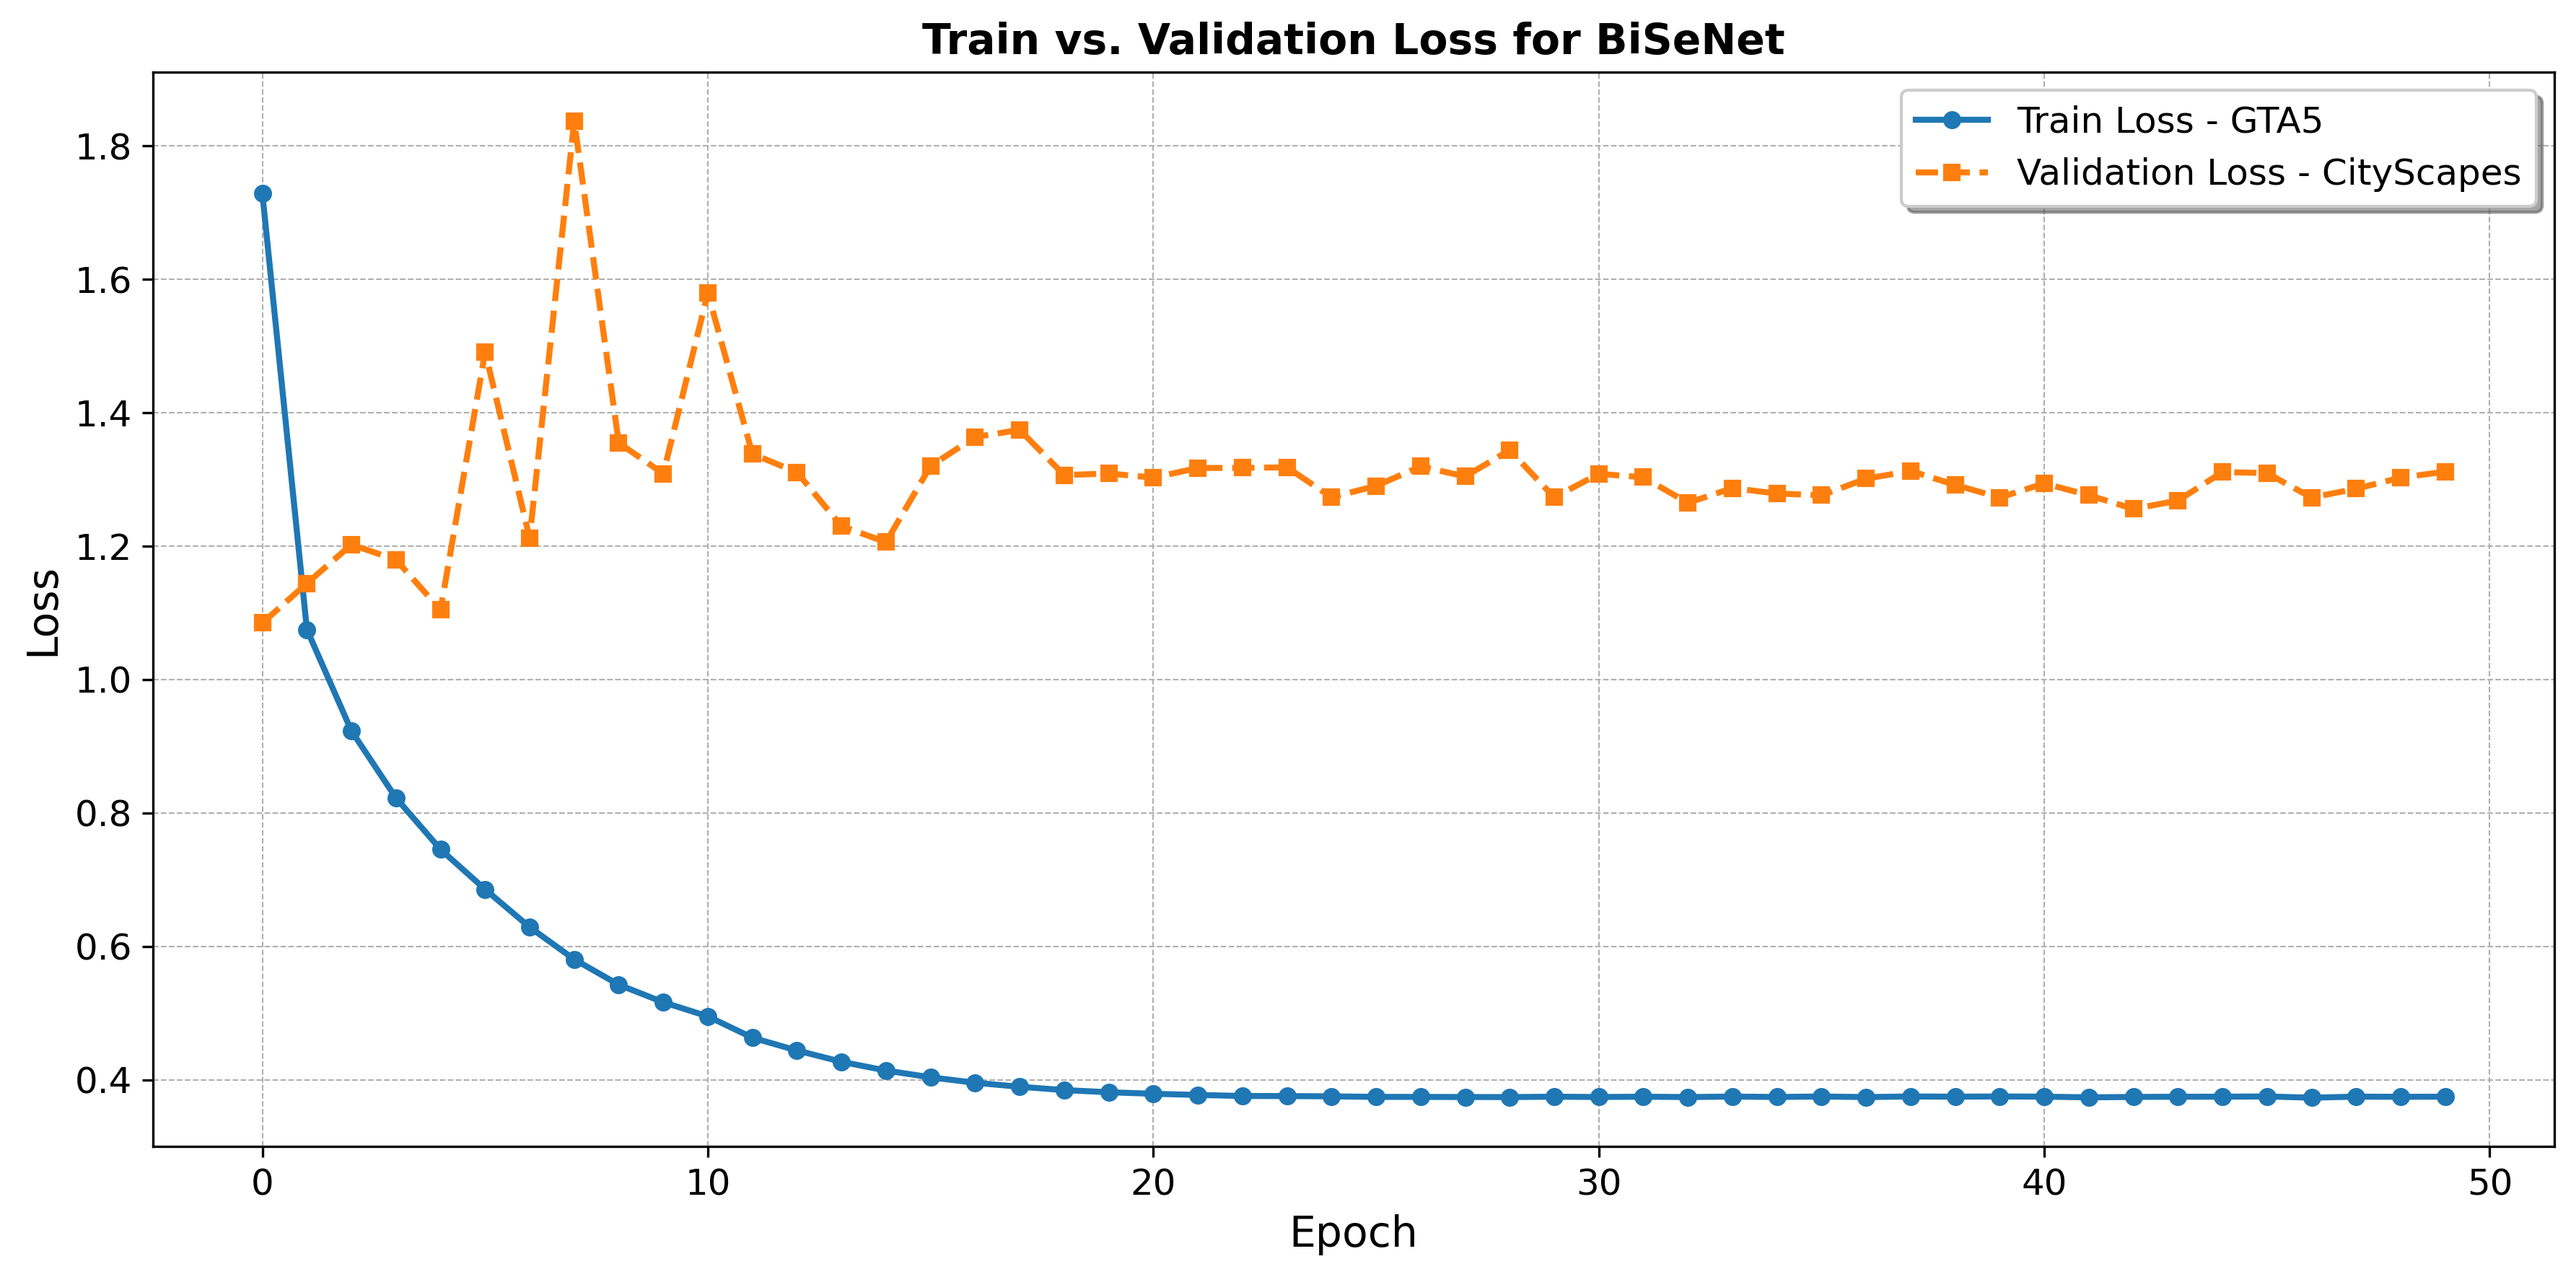

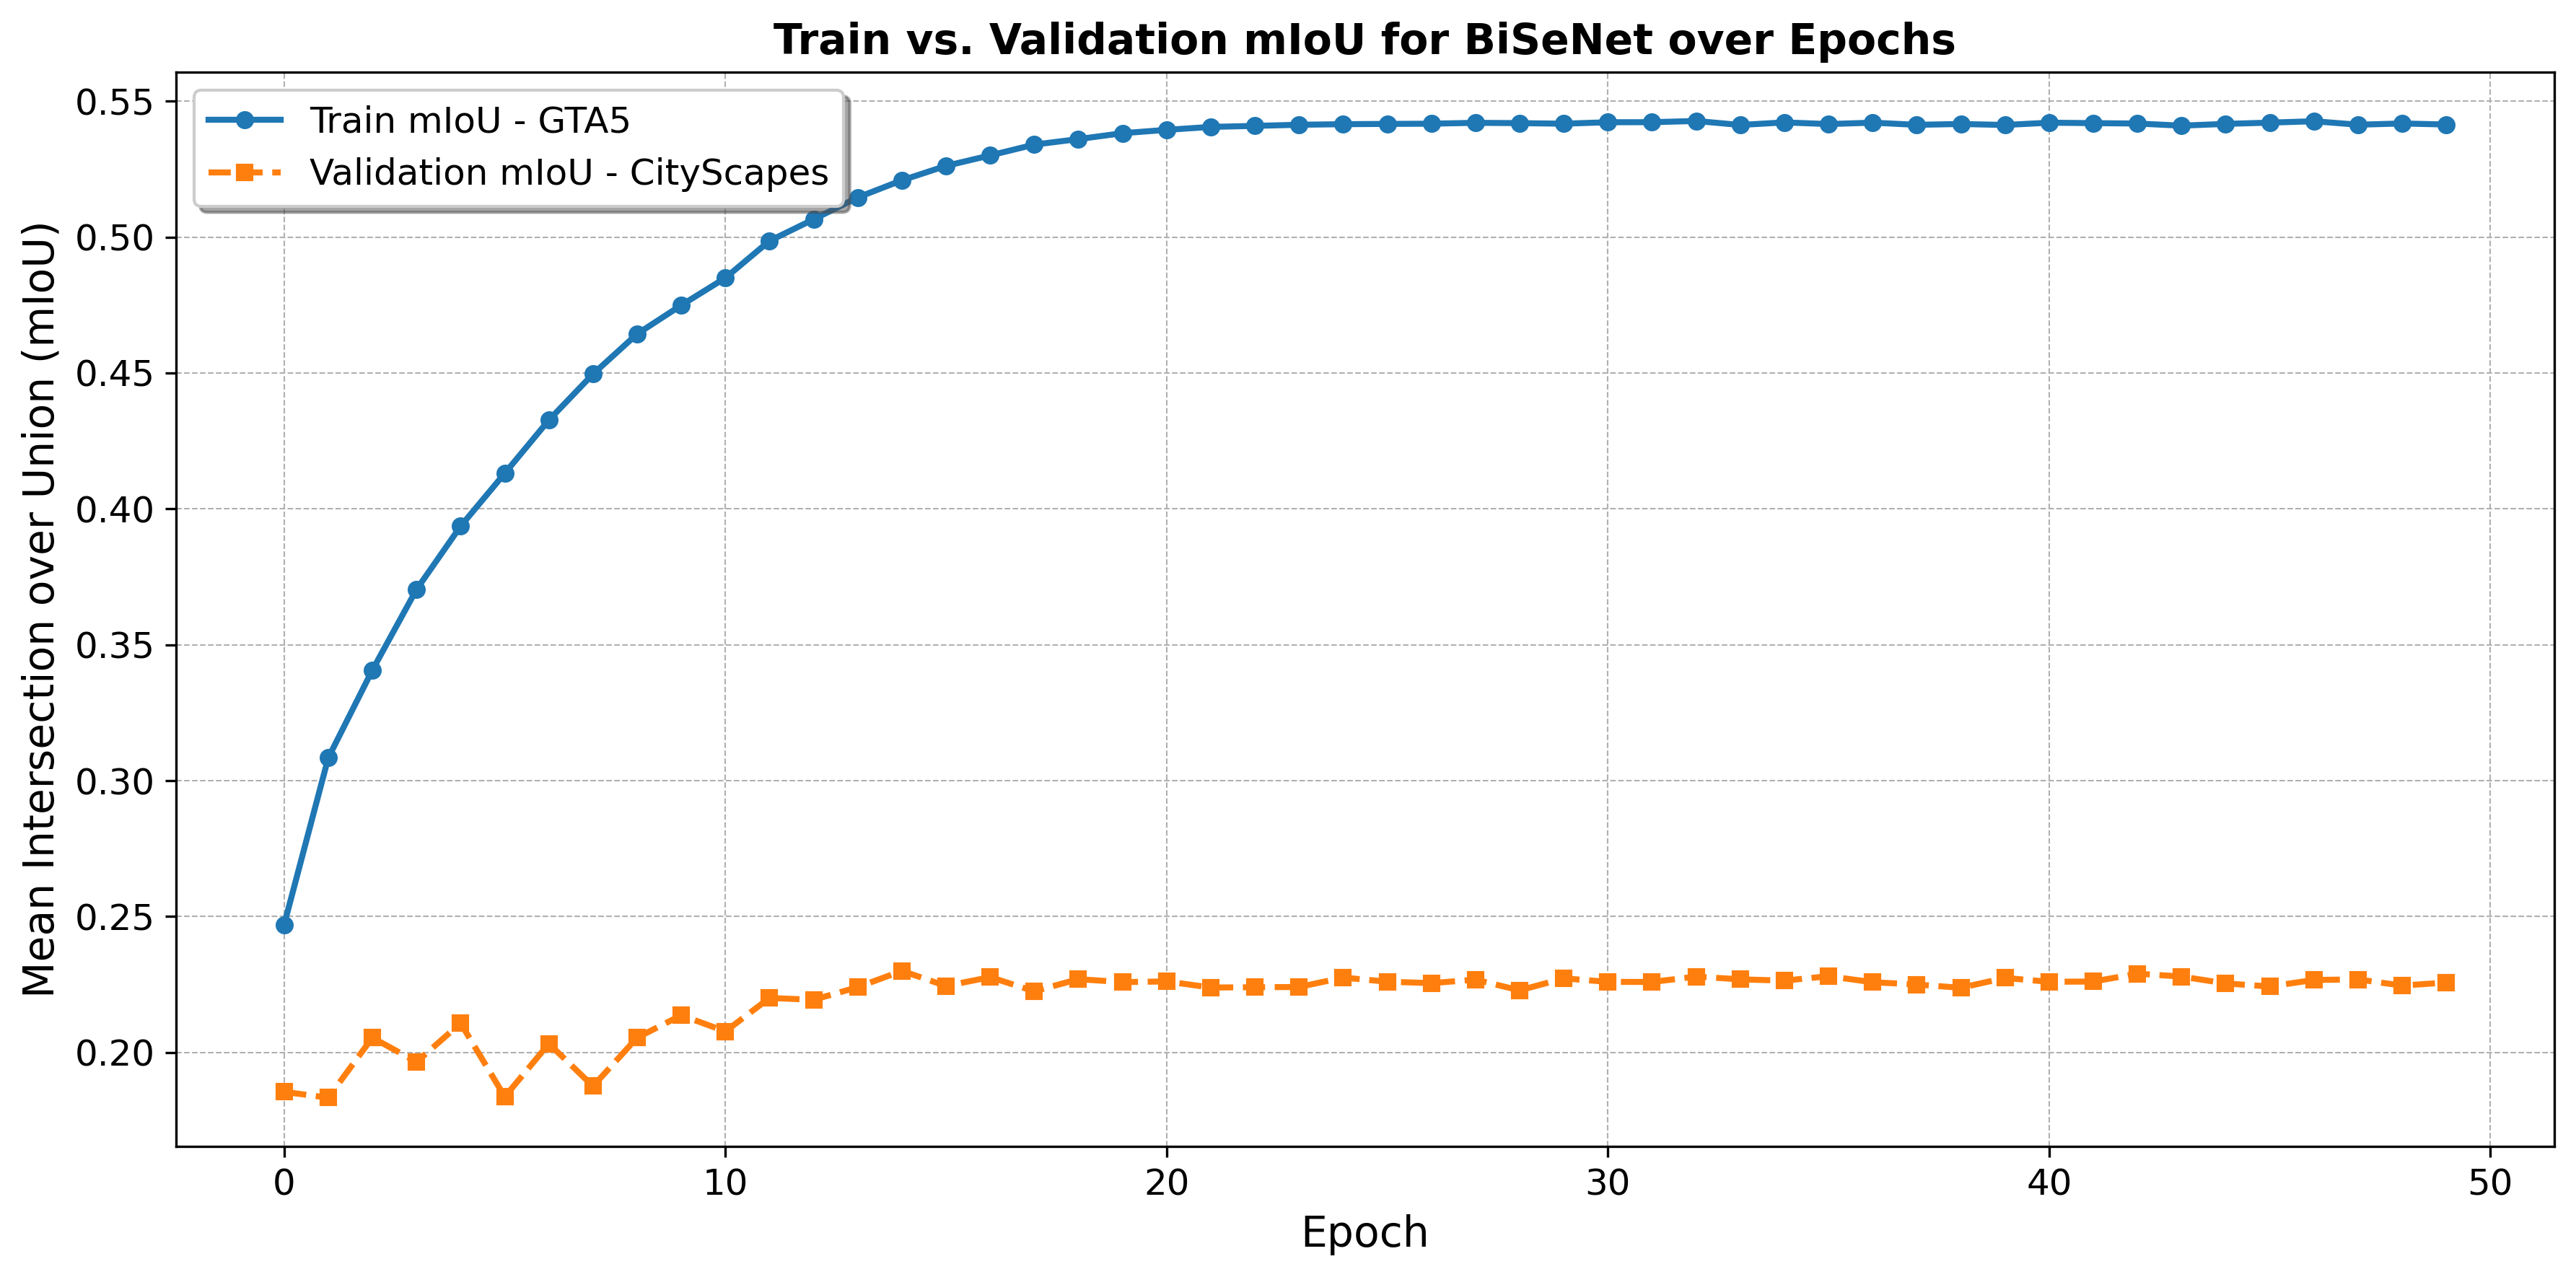

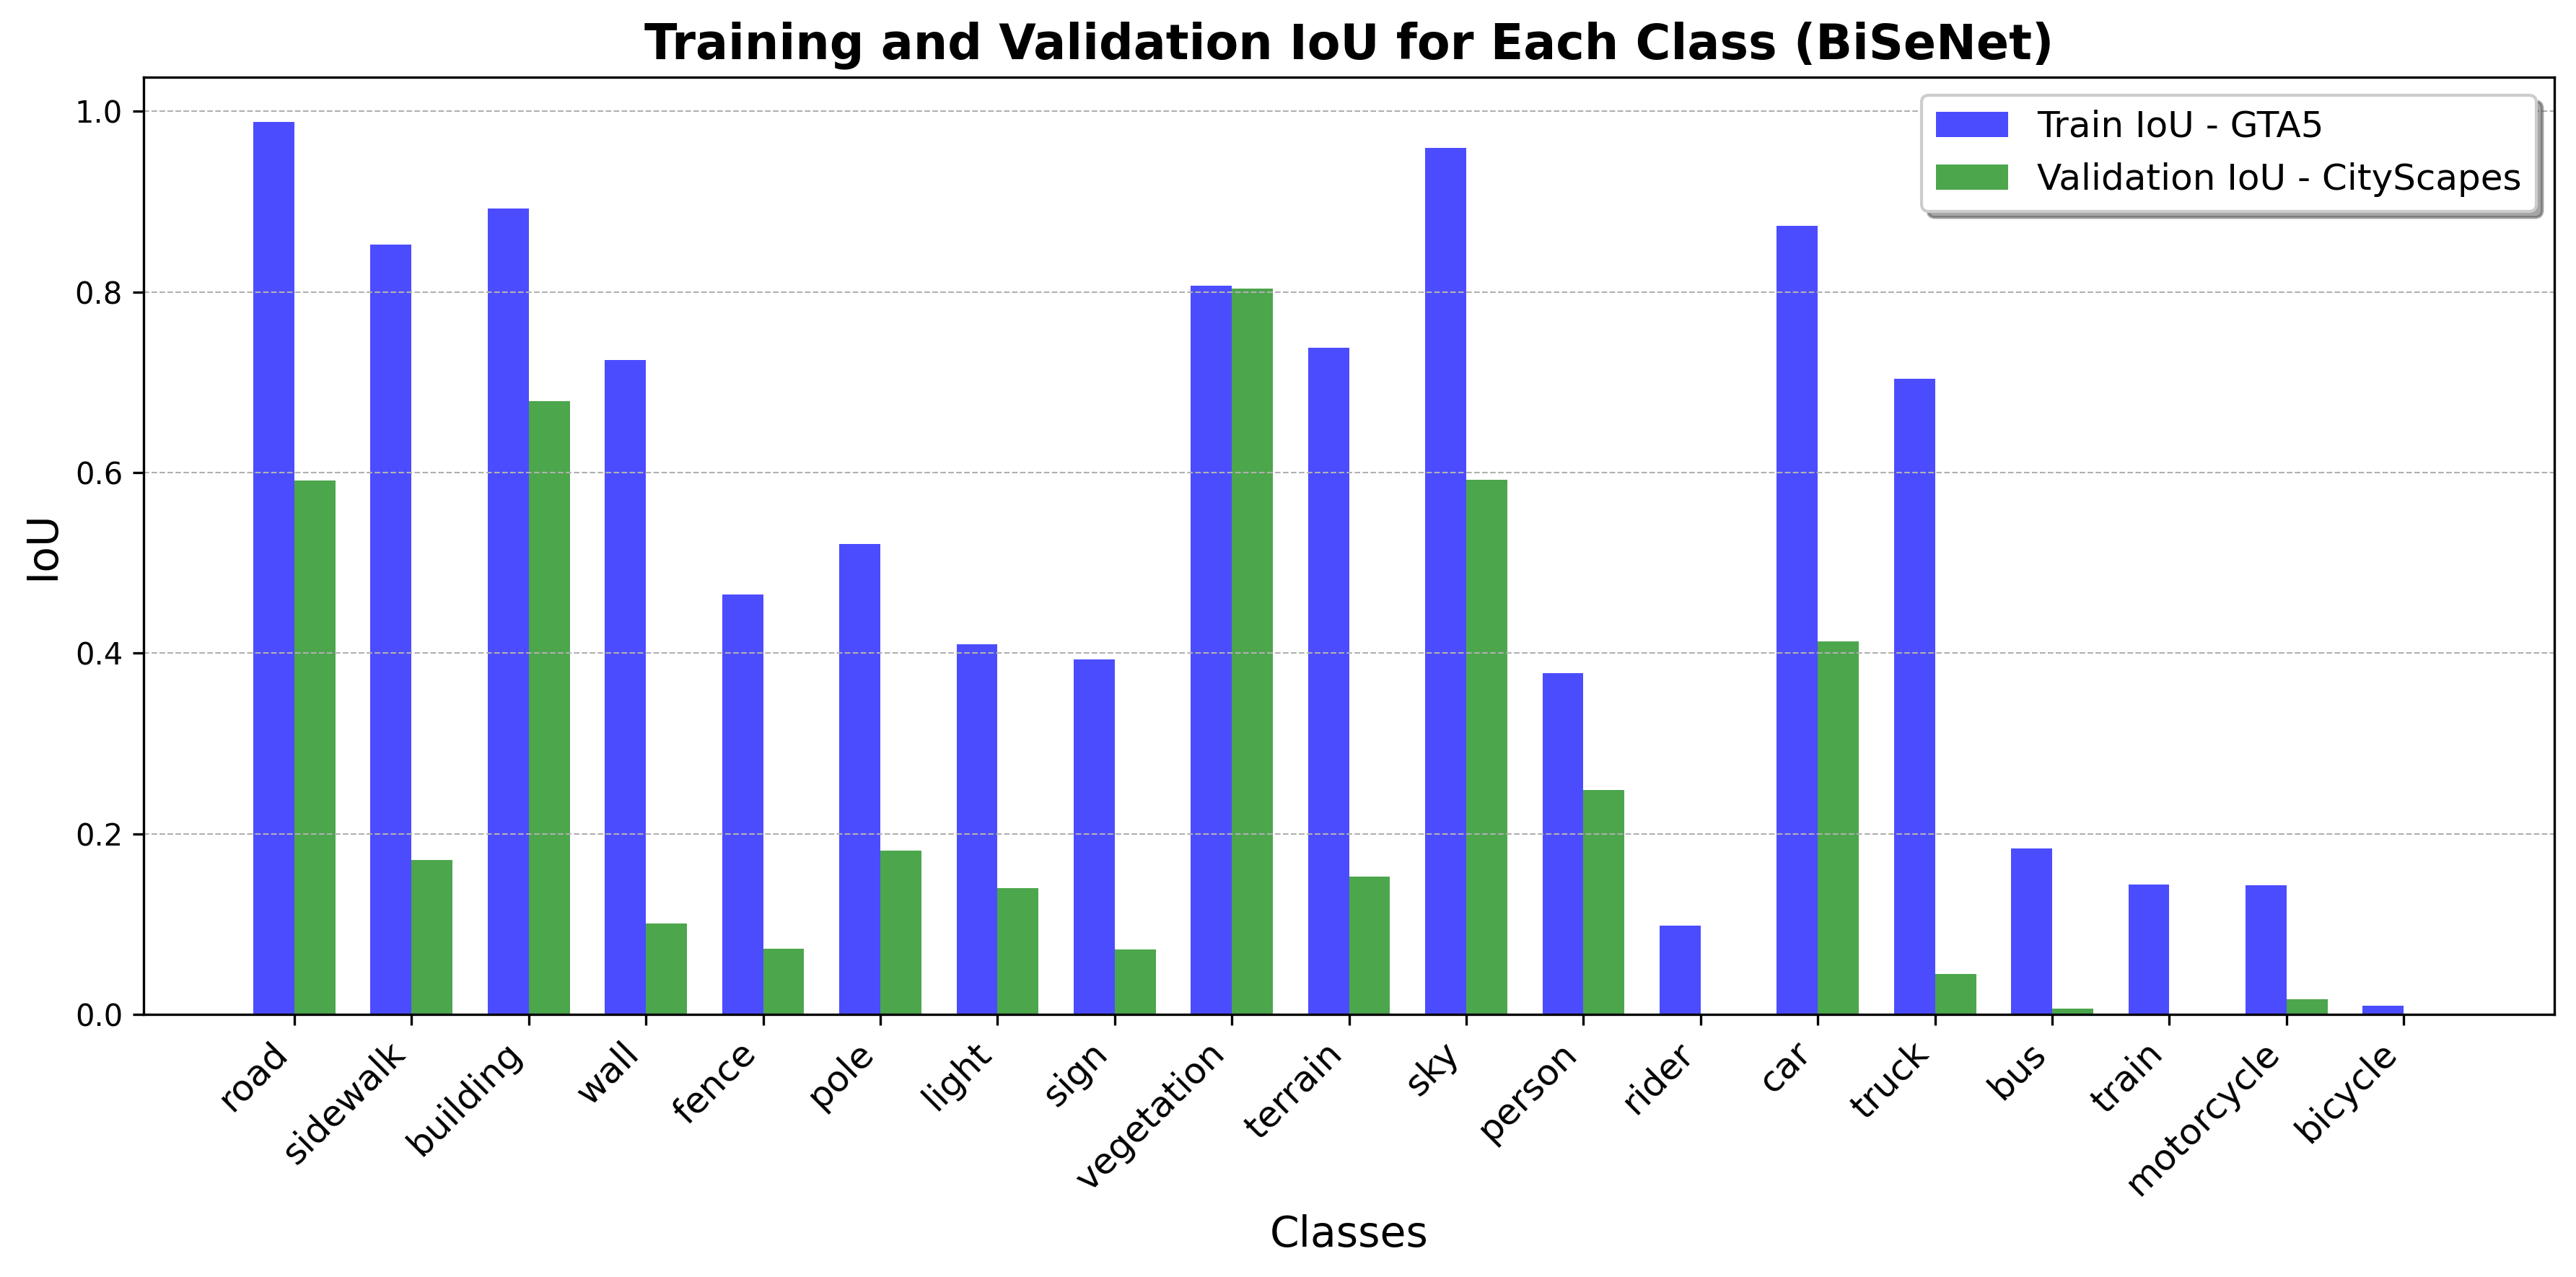

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.7724226675987245, Validation Loss: 1.4270676488876344
Train mIoU: 0.2426184224098785, Validation mIoU: 0.1502815494349076
Epoch: 1
Train Loss: 1.1171501985549928, Validation Loss: 1.0783542394638062
Train mIoU: 0.30525436516537047, Validation mIoU: 0.18484363311251184
Epoch: 2
Train Loss: 0.9567428876876831, Validation Loss: 0.9799071264266968
Train mIoU: 0.3427921739983789, Validation mIoU: 0.20188920739172644
Epoch: 3
Train Loss: 0.8599999354362488, Validation Loss: 0.8751614527702332
Train mIoU: 0.3697494961293064, Validation mIoU: 0.22248153315031982
Epoch: 4
Train Loss: 0.7941300742149353, Validation Loss: 0.8408008866310119
Train mIoU: 0.3894289277677825, Validation mIoU: 0.2307754458225587
Epoch: 5
Train Loss: 0.717285081577301, Validation Loss: 1.2813250794410707
Train mIoU: 0.4106875917010831, Validation mIoU: 0.20109636567010672
Epoch: 6
Train Loss: 0.6563638708591462, Validation Loss: 1.5913560285568238
Train mIoU: 0.4297261253436047, Validation mIoU: 

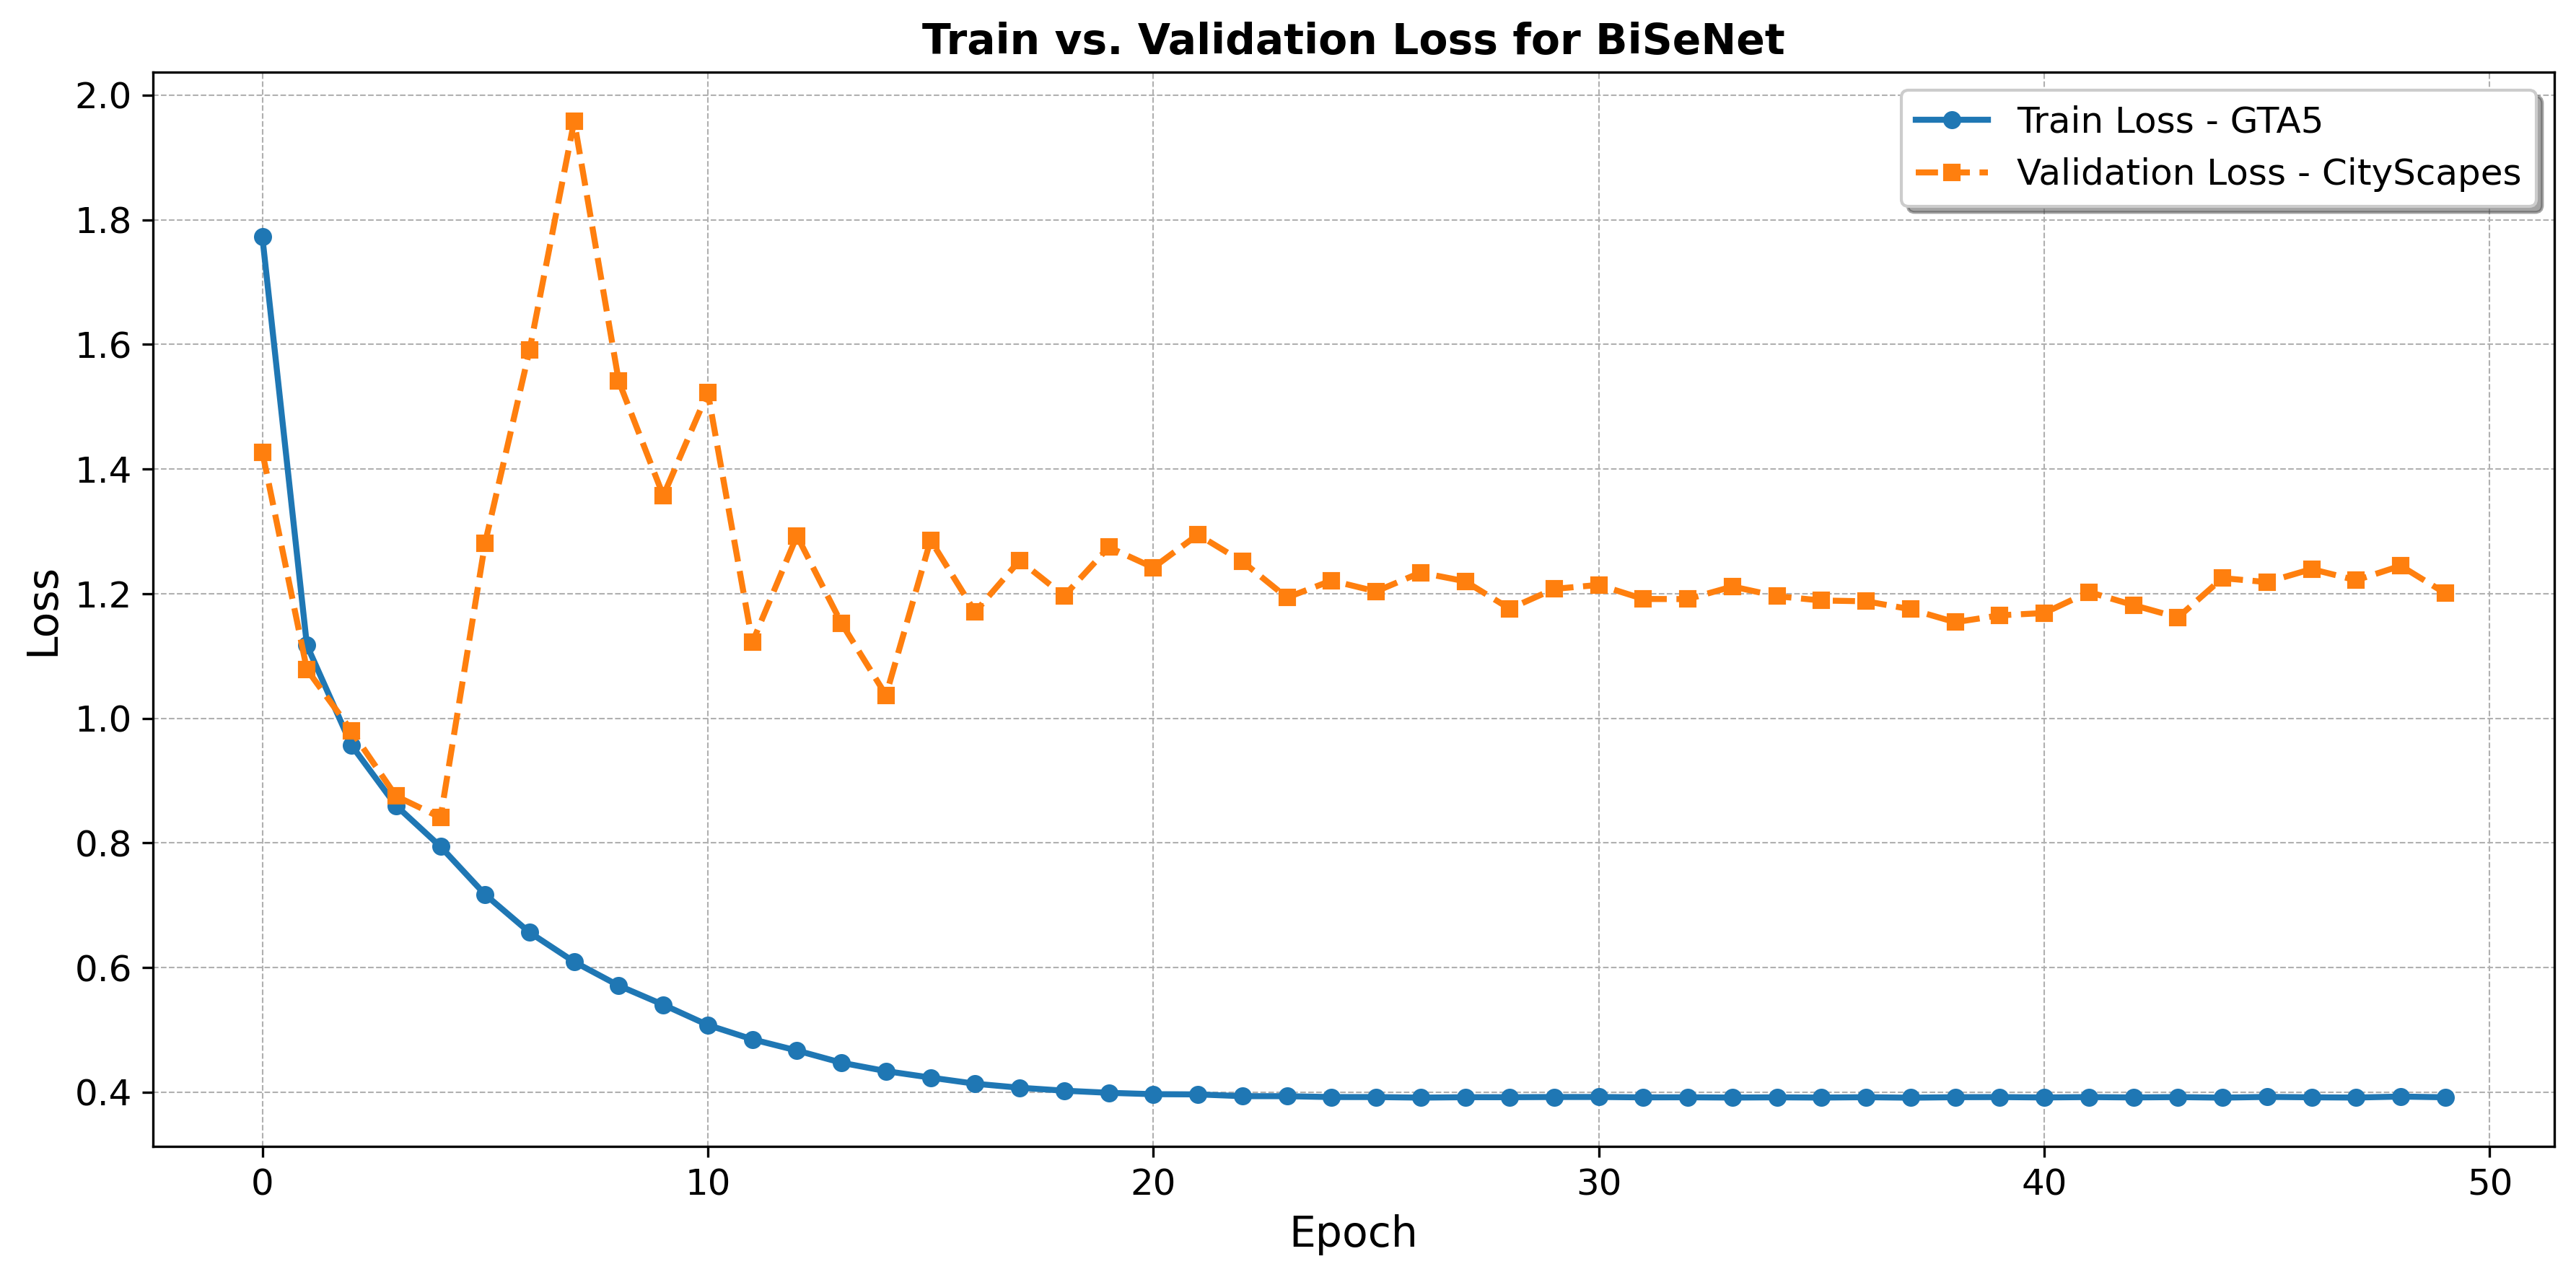

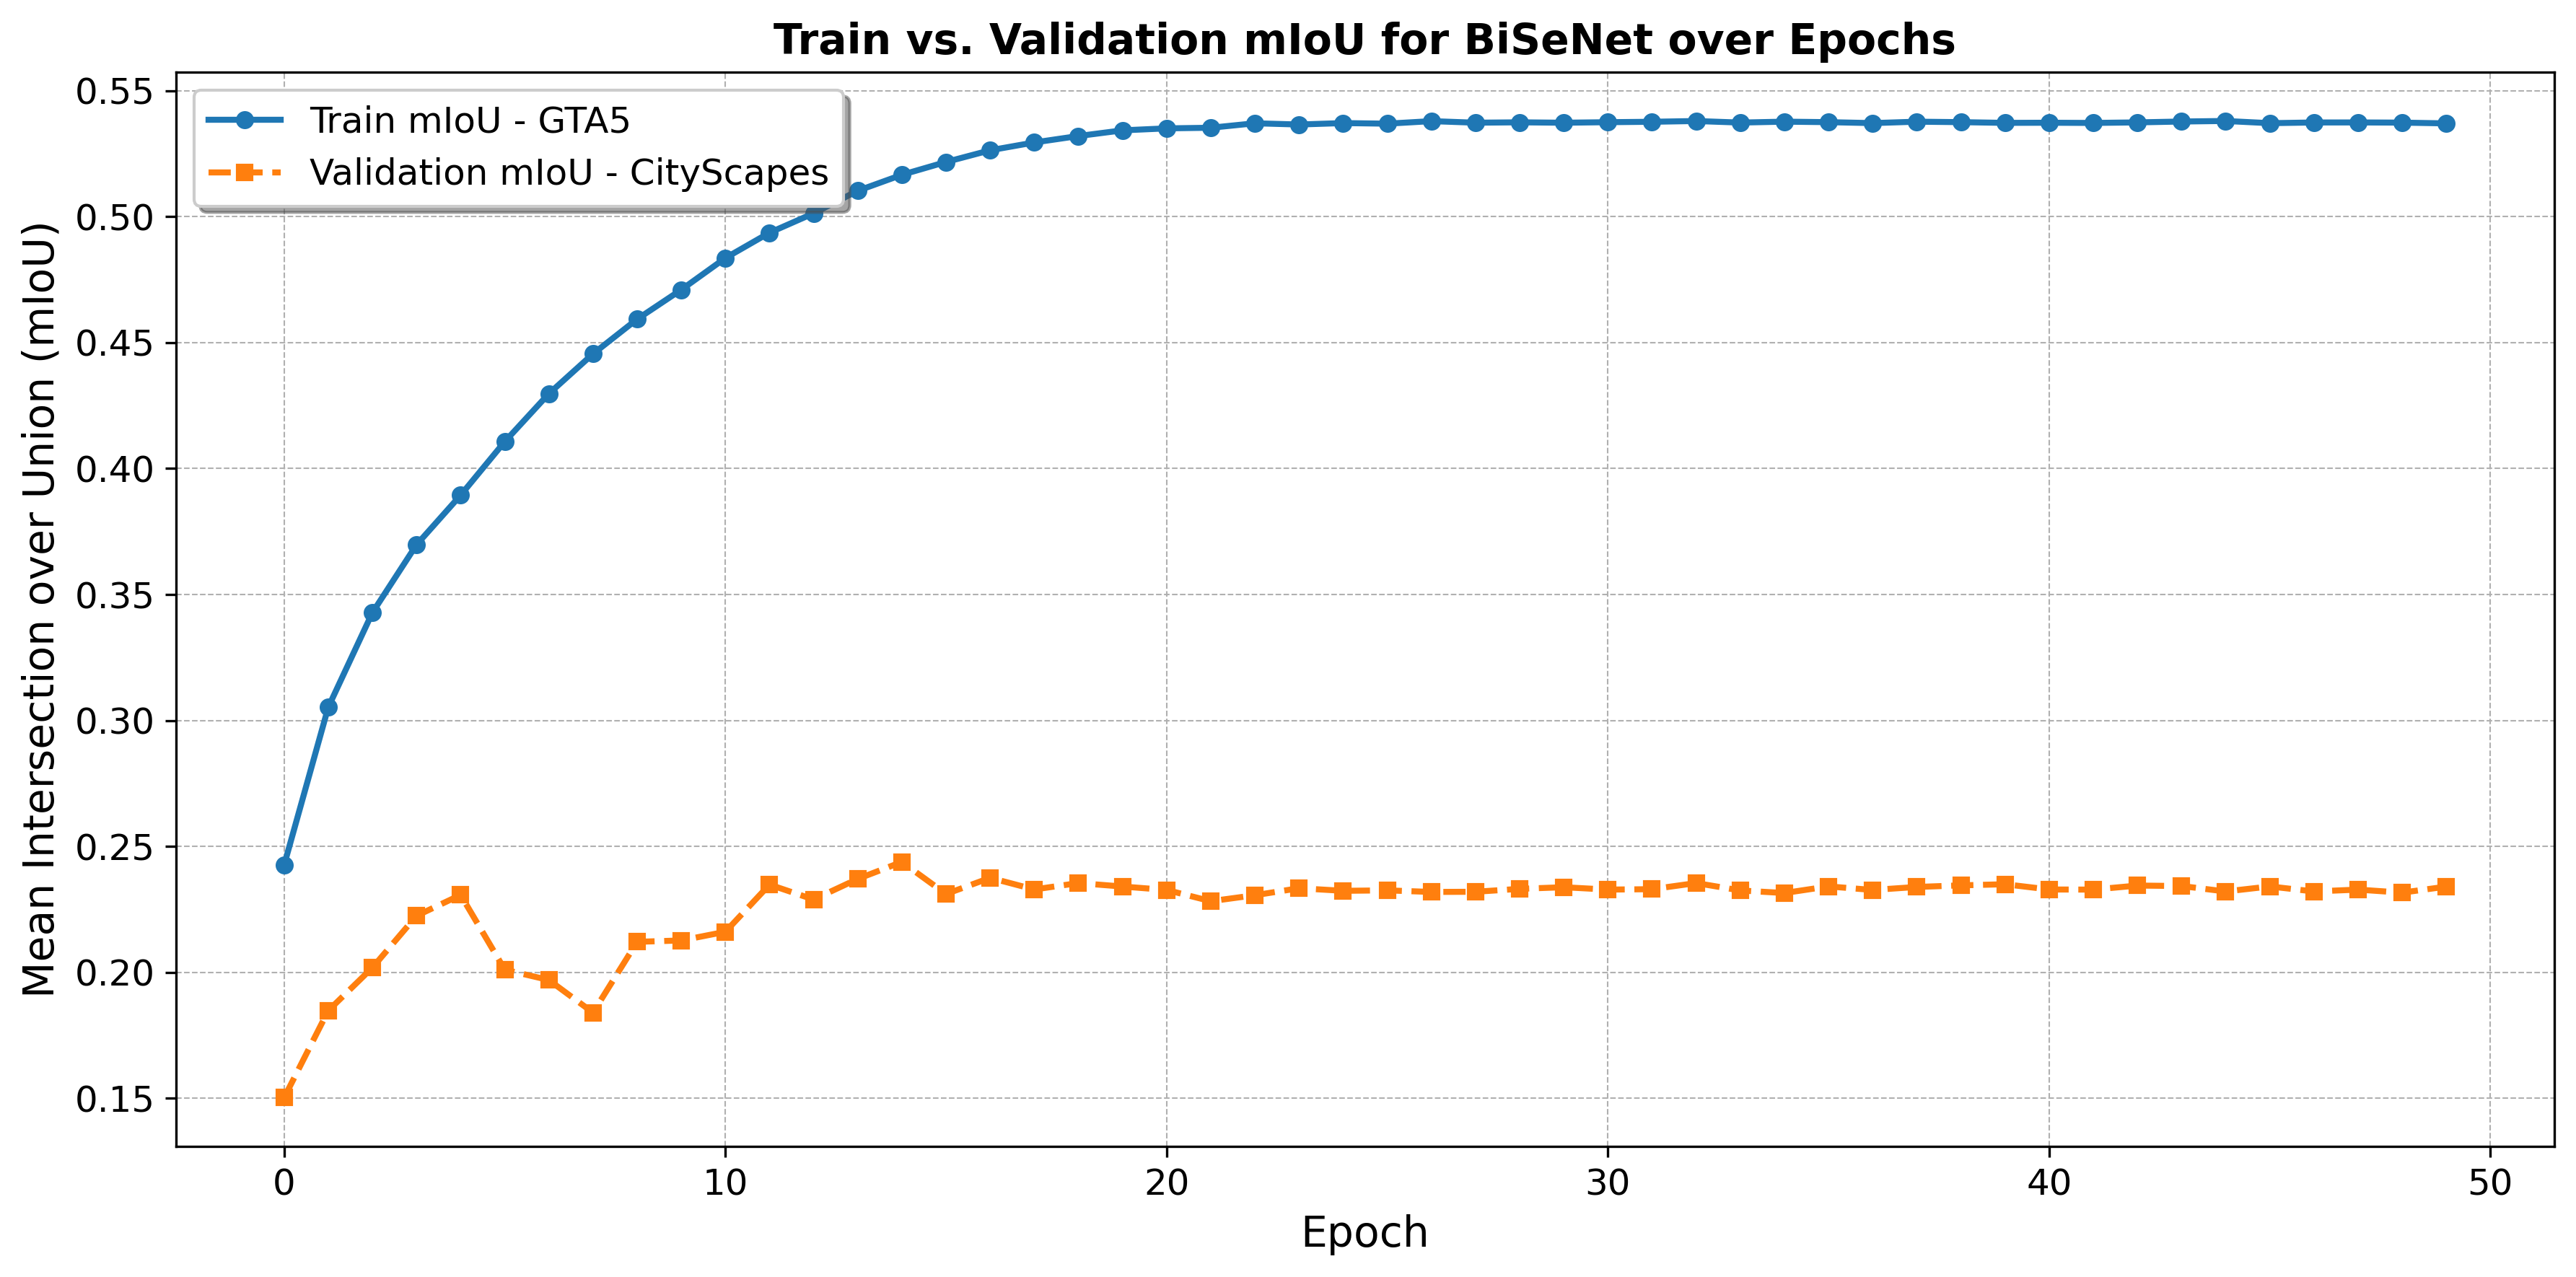

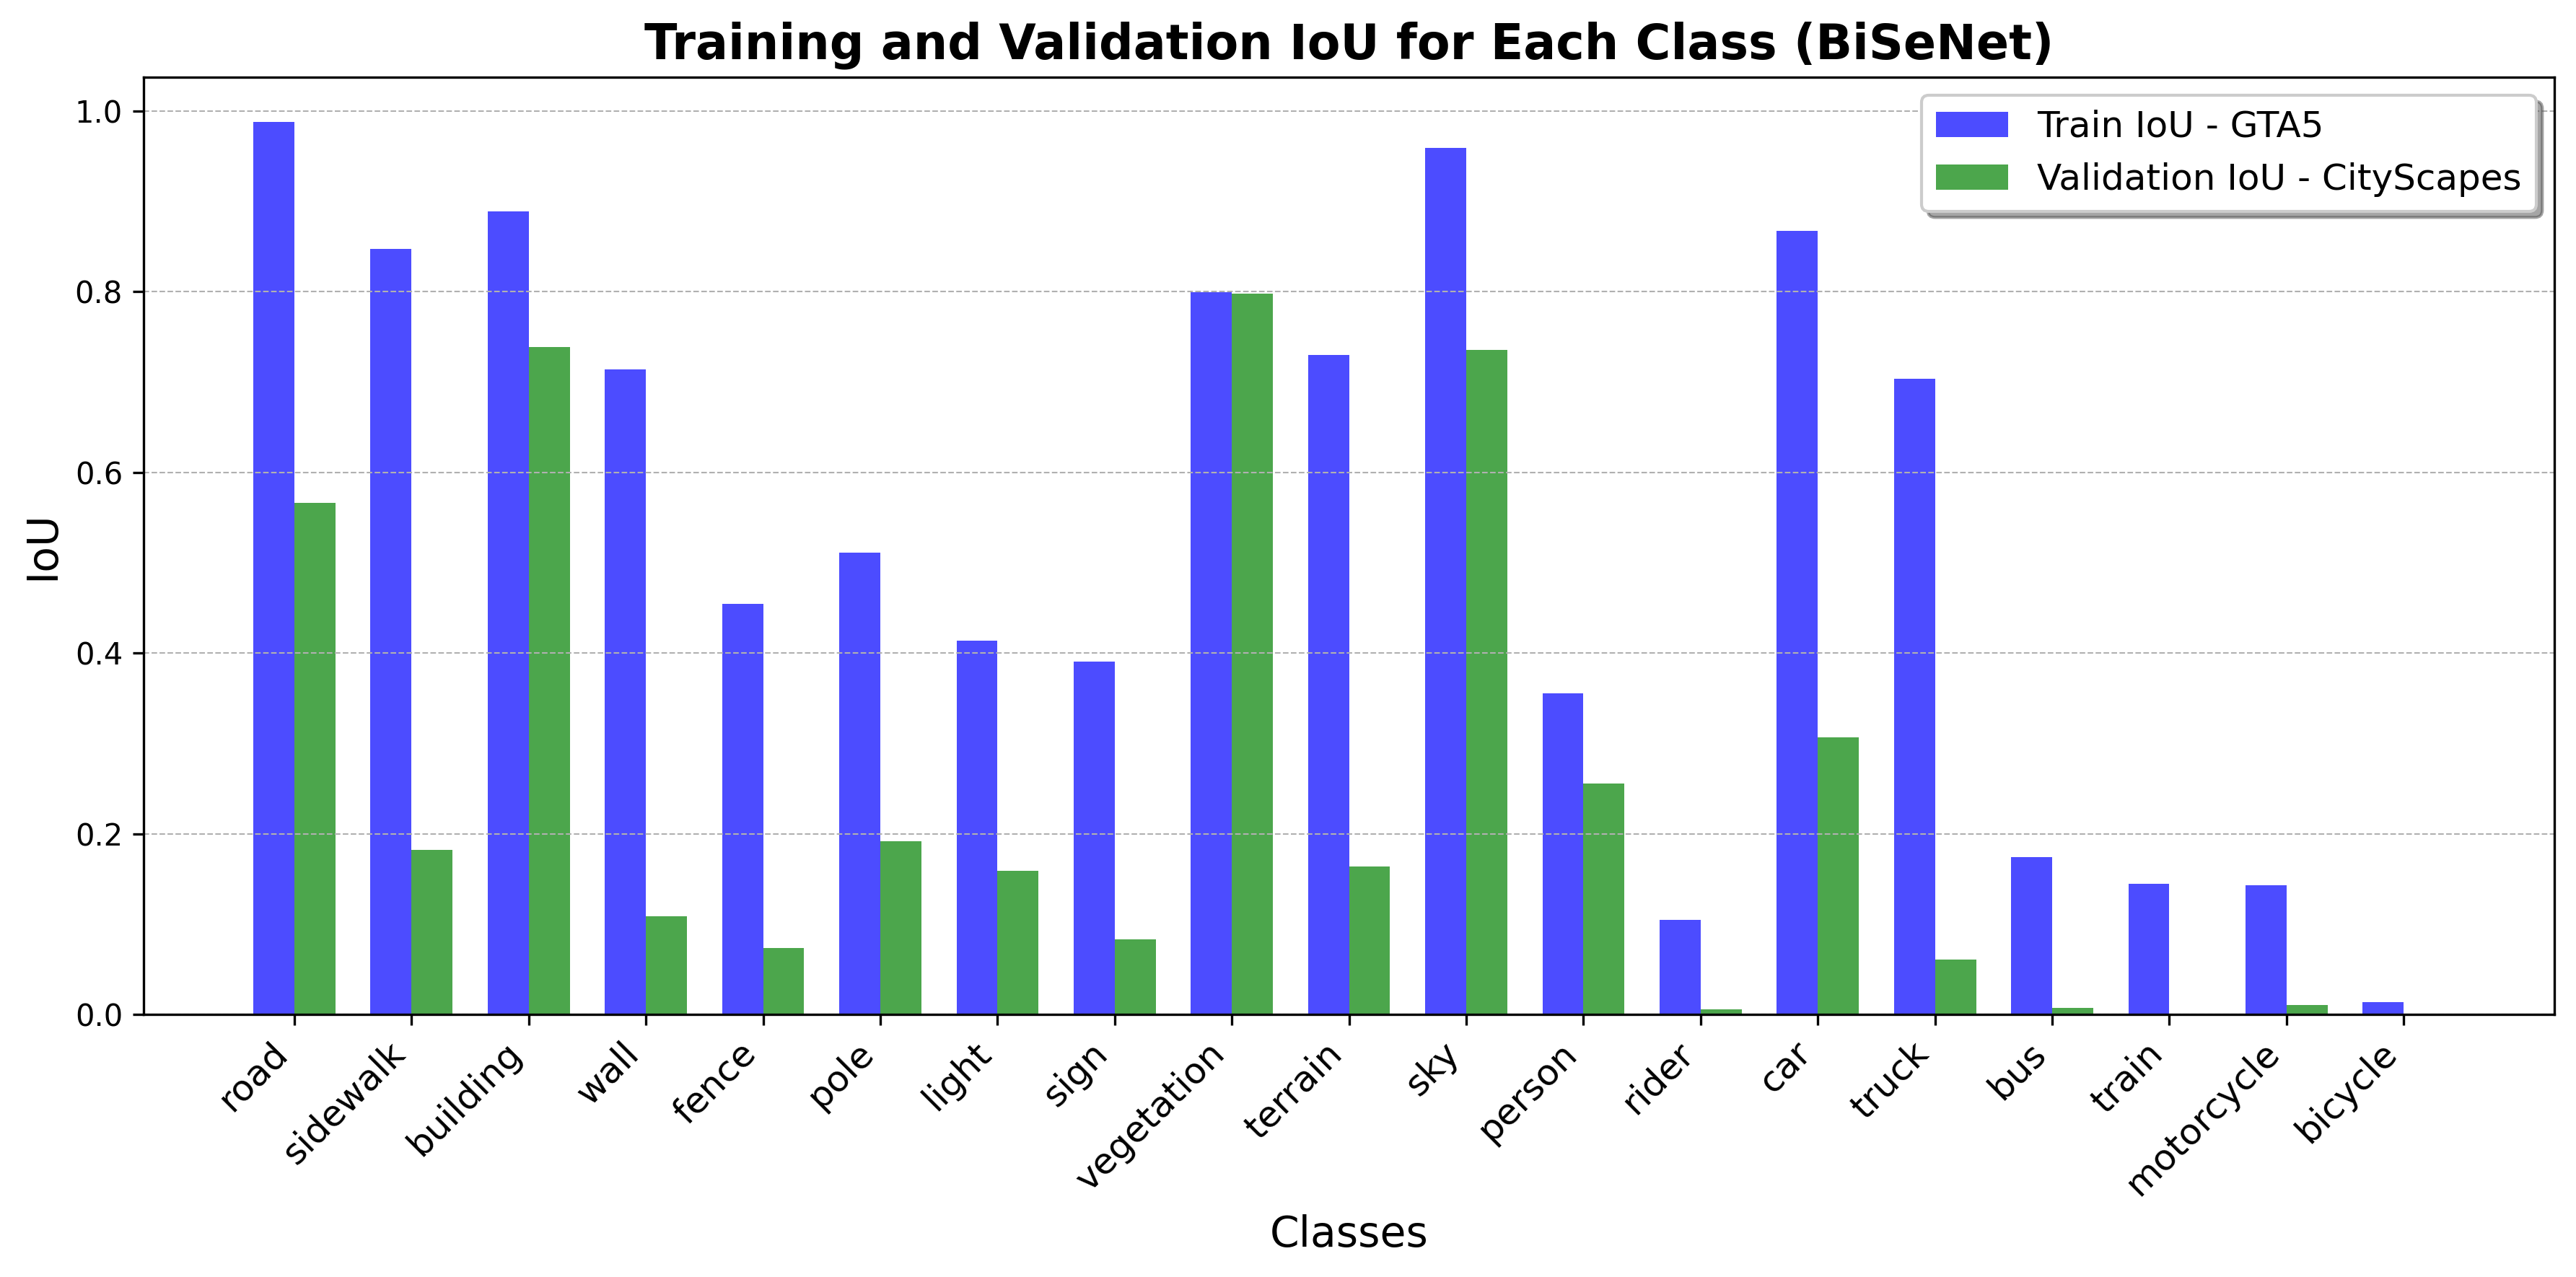

'transform2'

In [3]:

augmentations = {
    'transform1': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.5),

    ]),
    'transform2': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),

    ]),
    'transform3': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),

    ]),
    'transform4': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),

    ]),
    'transform5': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),

    ])
}
best_score = 0
best_transform = ''

# Evaluate each augmentation strategy
for transform_name, transform_pipeline in augmentations.items():
    # Prepare datasets with the current transformation
    cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transform_pipeline)
    cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transform_pipeline)
    GTA5_dataset = GTA5('./GTA5', transform=transform_pipeline)

    # Create dataloaders
    cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize model and optimizer
    model_bisenet_3_2 = BiSeNet(19, 'resnet18').to(device)
    if device == 'cuda' and torch.cuda.device_count() > 1:
        model_bisenet_3_2 = torch.nn.DataParallel(model_bisenet_3_2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.Adam(model_bisenet_3_2.parameters(), lr=7.5e-4)

    # Train the model
    bisenet_result3_2 = train(model=model_bisenet_3_2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              train_dataloader=GTA5_dataloader,
                              validation_dataloader=cityscapes_test_dataloader,
                              epochs=EPOCHS,
                              device=device,
                              model_name="bisenet",
                              class_number=NC)
    
    # Save and plot results
    save_results(model_bisenet_3_2, bisenet_result3_2, f"bisenet_performance_metrics_3_2_{transform_name}", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
    plot_loss(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    plot_mIoU(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    plot_IoU(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    
    # Save model checkpoint
    torch.save(model_bisenet_3_2.state_dict(), f"./checkpoints/bisenet_model_3_2_{transform_name}.pth")
    
    # Update best performing transformation
    if best_score < bisenet_result3_2[3][-1]:
        best_score = bisenet_result3_2[3][-1]
        best_transform = transform_name

best_transform


In [4]:

augmentations = {
    'transform5': A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),
        A.ColorJitter(p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),

    ])
}


# Evaluate each augmentation strategy
for transform_name, transform_pipeline in augmentations.items():
    # Prepare datasets with the current transformation
    cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transform_pipeline)
    cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transform_pipeline)
    GTA5_dataset = GTA5('./GTA5', transform=transform_pipeline)

    # Create dataloaders
    cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize model and optimizer
    model_bisenet_3_2 = BiSeNet(19, 'resnet18').to(device)
    if device == 'cuda' and torch.cuda.device_count() > 1:
        model_bisenet_3_2 = torch.nn.DataParallel(model_bisenet_3_2).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.Adam(model_bisenet_3_2.parameters(), lr=7.5e-4)

    # Train the model
    bisenet_result3_2 = train(model=model_bisenet_3_2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              train_dataloader=GTA5_dataloader,
                              validation_dataloader=cityscapes_test_dataloader,
                              epochs=EPOCHS,
                              device=device,
                              model_name="bisenet",
                              class_number=NC)
    
    # Save and plot results
    save_results(model_bisenet_3_2, bisenet_result3_2, f"bisenet_performance_metrics_3_2_{transform_name}", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
    plot_loss(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    plot_mIoU(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    plot_IoU(bisenet_result3_2, "BiSeNet", f"step3_2_{transform_name}", "GTA5", "CityScapes")
    
    # Save model checkpoint
    torch.save(model_bisenet_3_2.state_dict(), f"./checkpoints/bisenet_model_3_2_{transform_name}.pth")
    
    # Update best performing transformation
    if best_score < bisenet_result3_2[3][-1]:
        best_score = bisenet_result3_2[3][-1]
        best_transform = transform_name

best_transform


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 1.7924697107315064, Validation Loss: 1.2751712493896485
Train mIoU: 0.23882293411232317, Validation mIoU: 0.16257443062203125
Epoch: 1
Train Loss: 1.109252407360077, Validation Loss: 1.2452274355888366
Train mIoU: 0.3047478858793531, Validation mIoU: 0.18608277285721073
Epoch: 2
Train Loss: 0.9401753427505494, Validation Loss: 0.9423413262367248
Train mIoU: 0.3388995848434244, Validation mIoU: 0.19794191491796115
Epoch: 3
Train Loss: 0.8346551567554474, Validation Loss: 1.0851314849853515
Train mIoU: 0.3702123138772428, Validation mIoU: 0.19386336346769878
Epoch: 4
Train Loss: 0.7412926031589508, Validation Loss: 0.9742985625267029
Train mIoU: 0.3974498142217443, Validation mIoU: 0.20804776826564272
Epoch: 5
Train Loss: 0.6691360260486603, Validation Loss: 1.0243734731674194
Train mIoU: 0.4214998951770003, Validation mIoU: 0.21111775701281235
Epoch: 6
Train Loss: 0.6073641726493836, Validation Loss: 1.325411961078644
Train mIoU: 0.4430898069867832, Validation mIoU:

# 4.1 FDA

In [ ]:
GTA5_dataset = GTA5('./GTA5', transform=augmentations[best_transform], FDA = 0.09)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
model_bisenet_4_1_FDA = BiSeNet(19, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_4_1_FDA = torch.nn.DataParallel(model_bisenet_4_1_FDA).to(device)
init_lr = 7.5e-4 #0.0001
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model_bisenet_4_1_FDA.parameters(), lr=init_lr)

bisenet_result4_1_FDA = train(model = model_bisenet_4_1_FDA,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              train_dataloader = GTA5_dataloader,
                              validation_dataloader = cityscapes_test_dataloader,
                              epochs = EPOCHS,
                              device = device,
                              model_name = "bisenet",
                              class_number= NC)

    
save_results(model_bisenet_4_1_FDA, bisenet_result4_1_FDA, "bisenet_performance_metrics_4_1_FDA", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=10, device=device)
plot_loss(bisenet_result4_1_FDA, "BiSeNet", "step4_1_FDA", "GTA5", "CityScapes")
plot_mIoU(bisenet_result4_1_FDA, "BiSeNet", "step4_1_FDA", "GTA5", "CityScapes")
plot_IoU(bisenet_result4_1_FDA, "BiSeNet", "step4_1_FDA", "GTA5", "CityScapes")
torch.save(model_bisenet_4_1_FDA.state_dict(), f"./checkpoints/bisenet_model_4_1_FDA.pth")


# 4.2 DACS

1- In the paper they say that they are using pretrained model. but in pseudocode they say that they are initializing the model with random parameters.


In [ ]:
# GTA5_dataset = GTA5('./GTA5', transform=augmentations[best], FDA = 0.09)

sigma = 150 # 175 for gta5 size, 100 for cityscapes size
# GTA5_dataset = GTA5('./GTA5', transform=augmentations[best_transform], FDA = 0.09)

# GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
model_bisenet_4_2_DACS = BiSeNet(NC, 'resnet18').to(device)
if device == 'cuda' and torch.cuda.device_count() > 1:
    model_bisenet_4_2_DACS = torch.nn.DataParallel(model_bisenet_4_2_DACS).to(device)
init_lr = 7.5e-4 #0.0001
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model_bisenet_4_2_DACS.parameters(), lr=init_lr)

bisenet_result4_2_DACS = train(model = model_bisenet_4_2_DACS,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               train_dataloader= GTA5_dataloader,
                               validation_dataloader=cityscapes_test_dataloader,
                               target_dataloader=cityscapes_train_dataloader,
                               epochs=EPOCHS,
                               device = device,
                               model_name='bisenet',
                               )
save_results(model_bisenet_4_2_DACS, bisenet_result4_2_DACS, "bisenet_performance_metrics_4_2_DACS", height=CITYSCAPE_SIZE[0], width=CITYSCAPE_SIZE[1], iterations=100, device=device)
plot_loss(bisenet_result4_2_DACS, "BiSeNet", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")
plot_mIoU(bisenet_result4_2_DACS, "BiSeNet", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")
plot_IoU(bisenet_result4_2_DACS, "BiSeNet", "step4_2_DACS", "GTA5 + CityScapes (DACS)", "CityScapes")

torch.save(model_bisenet_4_2_DACS.state_dict(), "./checkpoints/bisenet_model_4_2_DACS.pth")
